In [2]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import zipfile
import io

def load_eeg_data(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        start_line = 0
        for i, line in enumerate(lines):
            if line.strip() and line.split()[0].isdigit():
                start_line = i
                break
        
        data = []
        for line in lines[start_line:]:
            values = line.strip().split()
            if len(values) >= 8:
                data.append([int(val) for val in values[:8]])
        
        df = pd.DataFrame(data, columns=[f'EEG_{i+1}' for i in range(8)])
        
        return df
    
    except Exception as e:
        print(f"Error loading file {file_path}: {str(e)}")
        return None

def process_eeg_data(df):
    if df is None:
        return None
    
    df = df / 1000
    df['Time'] = np.arange(len(df)) / 500
    
    return df

def load_and_process_all_eeg_data(input_dir="/kaggle/input/haptic4/Haptic MLMIRS - Copy", output_dir="/kaggle/working"):
    all_data = {}
    
    os.makedirs(output_dir, exist_ok=True)
    
    easy_files = glob(os.path.join(input_dir, "**", "*.easy"), recursive=True)
    
    if not easy_files:
        print(f"No .easy files found in {input_dir}")
        return all_data
    
    zip_path = os.path.join(output_dir, "processed_eeg_data.zip")
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file_path in easy_files:
            file_name = os.path.basename(file_path)
            print(f"Processing {file_name}...")
            
            raw_eeg = load_eeg_data(file_path)
            processed_eeg = process_eeg_data(raw_eeg)
            
            if processed_eeg is not None:
                key = os.path.splitext(file_name)[0]
                all_data[key] = processed_eeg
                
                # Save to CSV in memory
                csv_buffer = io.StringIO()
                processed_eeg.to_csv(csv_buffer, index=False)
                csv_buffer.seek(0)
                
                # Add CSV to zip file
                zipf.writestr(f"{key}.csv", csv_buffer.getvalue())
                
                print(f"Successfully processed {file_name}")
                print(f"  Samples: {len(processed_eeg)}")
                print(f"  Duration: {processed_eeg['Time'].max():.2f} seconds")
            else:
                print(f"Failed to process {file_name}")
            
            print()
    
    print(f"All processed EEG data saved to {zip_path}")
    return all_data

# Main execution
if __name__ == "__main__":
    # Load and process all EEG data
    eeg_data = load_and_process_all_eeg_data()

    # Print summary of processed data
    print("Summary of processed EEG data:")
    for file_name, df in eeg_data.items():
        print(f"\nData from {file_name}:")
        print(df.head())
        print("\nBasic stats:")
        print(df.describe())

    # Plot the first 1000 samples of the first EEG channel for each file
    plt.figure(figsize=(15, 5 * len(eeg_data)))
    for i, (file_name, df) in enumerate(eeg_data.items(), 1):
        plt.subplot(len(eeg_data), 1, i)
        plt.plot(df['Time'][:1000], df['EEG_1'][:1000])
        plt.title(f"First 1000 samples of EEG_1 for {file_name}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (µV)")
    plt.tight_layout()
    plt.savefig('/kaggle/working/eeg_plots.png')
    plt.close()

    print("\nEEG plots saved to /kaggle/working/eeg_plots.png")

    # Save a summary of the processed data
    summary_df = pd.DataFrame({
        'File': list(eeg_data.keys()),
        'Samples': [len(df) for df in eeg_data.values()],
        'Duration': [df['Time'].max() for df in eeg_data.values()]
    })
    summary_df.to_csv('/kaggle/working/eeg_summary.csv', index=False)
    print("\nSummary of processed EEG data saved to /kaggle/working/eeg_summary.csv")

Processing 20240831163329_S11 HMLMIRSR H_left.easy...
Successfully processed 20240831163329_S11 HMLMIRSR H_left.easy
  Samples: 5500
  Duration: 11.00 seconds

Processing 20240831164105_S11 HMLMIRSR H_circles.easy...
Successfully processed 20240831164105_S11 HMLMIRSR H_circles.easy
  Samples: 30000
  Duration: 60.00 seconds

Processing 20240831154628_S11 HMLMIRSR H_down.easy...
Successfully processed 20240831154628_S11 HMLMIRSR H_down.easy
  Samples: 5500
  Duration: 11.00 seconds

Processing 20240831153747_S11 HMLMIRSR H_circles.easy...
Successfully processed 20240831153747_S11 HMLMIRSR H_circles.easy
  Samples: 30000
  Duration: 60.00 seconds

Processing 20240831161351_S11 HMLMIRSR H_down.easy...
Successfully processed 20240831161351_S11 HMLMIRSR H_down.easy
  Samples: 5500
  Duration: 11.00 seconds

Processing 20240831154544_S11 HMLMIRSR H_left.easy...
Successfully processed 20240831154544_S11 HMLMIRSR H_left.easy
  Samples: 5500
  Duration: 11.00 seconds

Processing 20240831160247_

EGAF

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import math
from scipy.signal import resample
from scipy.interpolate import interp1d

# Create a directory to save results
os.makedirs('results', exist_ok=True)

def initialize_weights_kaiming(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            if isinstance(param, nn.Linear):
                nn.init.kaiming_uniform_(param.data, a=math.sqrt(5))
            elif isinstance(param, nn.Conv2d):
                nn.init.kaiming_normal_(param.data, mode='fan_out', nonlinearity='relu')
        elif 'bias' in name:
            if isinstance(param, nn.Linear) or isinstance(param, nn.Conv2d):
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(param)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(param.data, -bound, bound)

class AlphaSpatialDropout(nn.Module):
    def __init__(self, drop_prob):
        super(AlphaSpatialDropout, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # x: [batch_size, channels, height, width]
            # Generate alpha mask
            alpha_mask = torch.rand(x.shape[0], x.shape[1], 1, 1, device=x.device)
            alpha_mask = alpha_mask.expand(x.shape[0], x.shape[1], x.shape[2], x.shape[3])
            alpha_mask = (alpha_mask >= self.drop_prob).float() / (1 - self.drop_prob)
            
            # Apply mask and retain self-normalizing property
            return x * alpha_mask

class EEGAugmenter:
    def __init__(self, p=0.5):
        self.p = p

    def apply_augmentations(self, X, y):
        augmented_X, augmented_y = [], []
        orig_shape = X[0].shape
        
        for sample, label in zip(X, y):
            augmented_X.append(sample)
            augmented_y.append(label)
            
            if np.random.random() < self.p:
                aug_sample = self.time_warp(sample)
                aug_sample = self.adjust_shape(aug_sample, orig_shape)
                augmented_X.append(aug_sample)
                augmented_y.append(label)
            
            if np.random.random() < self.p:
                aug_sample = self.add_gaussian_noise(sample)
                augmented_X.append(aug_sample)
                augmented_y.append(label)
            
            if np.random.random() < self.p:
                aug_sample = self.scale_amplitude(sample)
                augmented_X.append(aug_sample)
                augmented_y.append(label)
            
            if np.random.random() < self.p:
                aug_sample = self.shift_time(sample)
                aug_sample = self.adjust_shape(aug_sample, orig_shape)
                augmented_X.append(aug_sample)
                augmented_y.append(label)

        return np.array(augmented_X), np.array(augmented_y)

    def adjust_shape(self, sample, target_shape):
        if sample.shape == target_shape:
            return sample
        elif sample.shape[1] > target_shape[1]:
            return sample[:, :target_shape[1]]
        else:
            padded = np.zeros(target_shape)
            padded[:, :sample.shape[1]] = sample
            return padded

    def time_warp(self, x, sigma=0.2, knot=4):
        orig_steps = np.arange(x.shape[1])
        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2))
        warp_steps = np.linspace(0, x.shape[1]-1., num=knot+2)
        warper = interp1d(warp_steps, random_warps, kind='cubic')
        warped_steps = warper(orig_steps)
        ret = np.apply_along_axis(self._time_warp_helper, 1, x, warped_steps)
        return ret

    def _time_warp_helper(self, x, warped_steps):
        return np.interp(warped_steps, np.arange(x.shape[0]), x)

    def add_gaussian_noise(self, x, noise_range=(0.01, 0.05)):
        noise_level = np.random.uniform(*noise_range)
        noise = np.random.normal(loc=0., scale=noise_level, size=x.shape)
        return x + noise

    def scale_amplitude(self, x, scale_range=(0.8, 1.2)):
        scale_factor = np.random.uniform(*scale_range)
        return x * scale_factor

    def shift_time(self, x, shift_range=(-10, 10)):
        shift = np.random.randint(*shift_range)
        return np.roll(x, shift, axis=1)

class AdvancedScaling(nn.Module):
    def __init__(self, alpha=100, learnable_alpha=False, full_range=False, epsilon=1e-6):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32), 
                                  requires_grad=learnable_alpha)
        self.full_range = full_range
        self.epsilon = epsilon

    def soft_extrema(self, x):
        # Soft maximum
        alpha_x = self.alpha * x
        max_term = torch.logsumexp(alpha_x, dim=0) / self.alpha
        
        # Soft minimum
        min_term = -torch.logsumexp(-alpha_x, dim=0) / self.alpha
        
        return min_term, max_term

    def scale_to_range(self, x):
        x_min, x_max = self.soft_extrema(x)
        x_scaled = (x - x_min) / (x_max - x_min + self.epsilon)
        return 2 * x_scaled - 1

    def forward(self, x):
        scaled = self.scale_to_range(x)
        if self.full_range:
            scaled = 2 * (scaled - scaled.min()) / (scaled.max() - scaled.min() + self.epsilon) - 1
        return torch.clamp(scaled, -1 + self.epsilon, 1 - self.epsilon)

    
    
class LearnableGASF(nn.Module):
    def __init__(self, input_dim, input_channels, feature_dim, output_dim):
        super(LearnableGASF, self).__init__()
        self.input_dim = input_dim
        self.input_channels = input_channels
        self.feature_dim = feature_dim
        self.output_dim = output_dim

        self.transform_x1 = nn.Linear(input_channels, feature_dim) #nn.Linear(input_channels, feature_dim) #
        self.transform_x2 = nn.Linear(input_channels, feature_dim) #nn.Linear(input_channels, feature_dim) #
        self.transform_t1 = nn.Linear(input_dim, output_dim) #nn.Linear(input_channels, feature_dim) #
        self.transform_t2 = nn.Linear(input_dim, output_dim) #nn.Linear(input_channels, feature_dim) #
        self.scaler = AdvancedScaling(alpha=20000, learnable_alpha=False, full_range=False)

    def forward(self, x):
        batch_size, channels, timesteps = x.shape

        # Channel transformations
        x = x.transpose(1, 2)
        x_transformed1 = self.transform_x1(x)
        x_transformed2 = self.transform_x2(x)
        x_transformed1 = x_transformed1.transpose(1, 2)
        x_transformed2 = x_transformed2.transpose(1, 2)

        #x_normalized1 = self.scaler(x_transformed1)
        #x_normalized2 = self.scaler(x_transformed2)

        phi1 = torch.arctan(x_transformed1)*2
        phi2 = torch.arctan(x_transformed2)*2

        # Time transformations
        phi_transformed1 = self.transform_t1(phi1)
        phi_transformed2 = self.transform_t2(phi2)

        # Compute GASF
        gasf = torch.sin(phi_transformed1.unsqueeze(3) - phi_transformed2.unsqueeze(2))
        
        return gasf


class ScaleAttention(nn.Module):
    def __init__(self, channels, num_scales, gamma=2, b=1):
        super(ScaleAttention, self).__init__()
        t = int(abs((math.log(num_scales, 2) + b) / gamma))
        k = t if t % 2 else t + 1
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(channels, channels, kernel_size=k, padding=(k - 1) // 2, bias=False)
        self.sigmoid = nn.Softmax(dim=1)

    def forward(self, x):
        num_scales, batch_size, channels, height, width = x.size()
        y = self.avg_pool(x.view(-1, channels, height, width)).view(num_scales, batch_size, channels)
        y = y.permute(1, 2, 0)
        y = self.conv(y)
        y = self.sigmoid(y)
        y = y.permute(2, 0, 1).unsqueeze(-1).unsqueeze(-1)
        return x * y
    
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(SeparableConv2d, self).__init__()

        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x
    
class FactorizedSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, factorization='kronecker', rank=None):
        super(FactorizedSeparableConv2d, self).__init__()

        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.factorization = factorization
        self.rank = rank if rank is not None else min(in_channels, kernel_size)

        if factorization == 'kronecker':
            self.factor1 = nn.Parameter(torch.randn(in_channels, self.rank))
            self.factor2 = nn.Parameter(torch.randn(self.rank, kernel_size * kernel_size))
        elif factorization == 'cp':
            self.factors = nn.ParameterList([nn.Parameter(torch.randn(in_channels, kernel_size * kernel_size)) for _ in range(self.rank)])
        else:
            raise ValueError(f"Unsupported factorization: {factorization}")

        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def kronecker_product(self):
        return torch.matmul(self.factor1, self.factor2).view(self.in_channels, 1, self.kernel_size, self.kernel_size)

    def cp_decomposition(self):
        return torch.stack([factor.view(self.in_channels, 1, self.kernel_size, self.kernel_size) for factor in self.factors], dim=0).sum(dim=0)

    def forward(self, x):
        if self.factorization == 'kronecker':
            kernel = self.kronecker_product()
        elif self.factorization == 'cp':
            kernel = self.cp_decomposition()

        x = F.conv2d(x, kernel, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=self.in_channels)
        x = self.pointwise(x)
        return x

class MultiscaleDilatedConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, scales, stride=1):
        super(MultiscaleDilatedConv, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride,
                      padding=dilation * (kernel_size - 1) // 2, dilation=dilation)
            for dilation in scales
        ])
        
        self.SConv = nn.ModuleList([
            FactorizedSeparableConv2d(in_channels, out_channels, kernel_size, stride=stride,
                      padding=dilation * (kernel_size - 1) // 2, dilation=dilation, factorization='cp', rank=2)
            for dilation in scales
        ])
        self.scale_attention = ScaleAttention(out_channels, len(scales))

    def forward(self, x):
        conv_outputs = torch.stack([conv(x) for conv in self.SConv])
        attended_outputs = self.scale_attention(conv_outputs)
        return torch.sum(attended_outputs, dim=0)

class MultiscaleDilatedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, scales):
        super(MultiscaleDilatedResidualBlock, self).__init__()
        self.conv1 = MultiscaleDilatedConv(in_channels, out_channels, kernel_size, scales)
        self.conv2 = MultiscaleDilatedConv(out_channels, out_channels, kernel_size, scales)
        #self.norm = nn.LayerNorm([out_channels, 50, 50])
        self.norm = nn.BatchNorm2d(out_channels)
        #self.alpha_dropout = nn.AlphaDropout(p=0.2)
        #self.alpha_dropout = nn.Dropout2d(p=0.4)
        self.asd = AlphaSpatialDropout(0.15)
        self.residual = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        residual = self.residual(x)
        out1 = F.selu(self.conv1(x)) + residual
        #out = self.alpha_dropout(out1)
        out = self.asd(out1)
        out = self.conv2(out) #+ residual + out1
        out = self.norm(out)
        out += residual  + out1
        return F.selu(out)

class ImprovedMultiscaleDilatedResNet(nn.Module):
    def __init__(self, input_dim, input_channels, feature_dim, output_dim, num_classes=6):
        super(ImprovedMultiscaleDilatedResNet, self).__init__()
        self.gasf_layer = LearnableGASF(input_dim, input_channels, feature_dim, output_dim)
        self.conv1 = FactorizedSeparableConv2d(feature_dim, 128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(128)
        self.blocks = nn.Sequential(
            MultiscaleDilatedResidualBlock(128, 128, kernel_size=5, scales=[4, 16, 256]))#,
            #*[MultiscaleDilatedResidualBlock(128, 128, kernel_size=5, scales=[4, 16, 256]) for _ in range(2)]
        #)
        self.SConv1 = FactorizedSeparableConv2d(128, 128, kernel_size = 5, dilation = 4)
        self.SConv2 = FactorizedSeparableConv2d(128, 128, kernel_size = 5, dilation = 8)
        self.global_avg_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.alpha_dropout = nn.AlphaDropout(0.1)
        self.softmax = nn.Softmax(dim=1)  # Specify dimension for softmax
        self.Drop2d = nn.Dropout2d(0.1)

    def forward(self, x):
        #print(x.shape)
        gasf = self.gasf_layer(x)
        #print(x.shape)
        x = F.selu(self.bn1(self.conv1(gasf)))
        #print(x.shape)
        #x = self.bn1(x)
        #x = self.blocks(x)
        x =  F.selu(self.SConv1(x))
        #print(x.shape)
        x = self.Drop2d(x)
        x =  F.selu(self.bn2(self.SConv2(x)))
        #print(x.shape)
        x = self.Drop2d(x)
        #x = self.bn2(x)
        x = self.global_avg_pool(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = F.selu(self.fc1(x))
        #print(x.shape)
        x = self.alpha_dropout(x)
        x = self.fc2(x)
        #print(x.shape)
        return x, gasf  # Return both the final output and the GASF representation

def prepare_data(eeg_data_dict, window_size=150, stride=75, chunk_size=1000):
    X = []
    y = []
    label_encoder = LabelEncoder()
    
    for full_class_name, eeg_data in eeg_data_dict.items():
        class_name = extract_class_name(full_class_name)
        if class_name is None:
            print(f"Skipping class: {full_class_name}")
            continue
        
        eeg_data = eeg_data.drop('Time', axis=1, errors='ignore')
        n_samples, n_channels = eeg_data.shape
        print(f"Class: {class_name} (from {full_class_name}), Shape: {eeg_data.shape}")
        
        eeg_array = eeg_data.values.T
        
        n_chunks = n_samples // chunk_size
        for chunk in range(n_chunks):
            chunk_start = chunk * chunk_size
            chunk_end = (chunk + 1) * chunk_size
            chunk_data = eeg_array[:, chunk_start:chunk_end]
            
            n_windows = (chunk_size - window_size) // stride + 1
            for w in range(n_windows):
                start = w * stride
                end = start + window_size
                window = chunk_data[:, start:end]
                X.append(window)
                y.append(class_name)
    
    X = np.array(X)
    y = np.array(y)
    y_encoded = label_encoder.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
    
    print("\nPrepared data summary:")
    print(f"Total samples: {X.shape[0]}")
    print(f"Features shape: {X.shape[1:]}")
    print(f"Number of classes: {len(np.unique(y))}")
    print(f"Classes: {label_encoder.classes_}")
    print(f"\nTrain set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, label_encoder

def extract_class_name(full_name):
    valid_classes = ['right', 'left', 'up', 'down', 'forward', 'backwards']
    for class_name in valid_classes:
        if class_name in full_name.lower():
            return class_name
    return None

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)  # Ignore the GASF output during training
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)  # Ignore the GASF output during testing
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(dim=1)).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.argmax(dim=1).cpu().numpy())
    accuracy = 100 * correct / total
    return running_loss / len(test_loader), accuracy, all_preds, all_labels

def plot_learned_gasf(model, inputs, labels, label_encoder, num_samples=5):
    model.eval()
    with torch.no_grad():
        _, gasf_outputs = model(inputs[:num_samples])
    
    plt.figure(figsize=(15, 3*num_samples))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(gasf_outputs[i, 0].cpu().numpy(), cmap='viridis', aspect='auto')
        plt.title(f"Class: {label_encoder.inverse_transform([labels[i].item()])[0]}")
        plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_and_save(fig, filename):
    plt.tight_layout()
    plt.savefig(os.path.join('results', filename))
    plt.close(fig)

def plot_learned_gasf(model, inputs, labels, label_encoder, num_samples=4):
    model.eval()
    with torch.no_grad():
        _, gasf_outputs = model(inputs[:num_samples])
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    for i, ax in enumerate(axs.flat):
        if i < num_samples:
            im = ax.imshow(gasf_outputs[i, 0].cpu().numpy(), cmap='viridis', aspect='auto')
            ax.set_title(f"Class: {label_encoder.inverse_transform([labels[i].item()])[0]}")
            fig.colorbar(im, ax=ax)
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plot_and_save(fig, 'learned_gasf_collage.png')

if __name__ == "__main__":
    # Assuming 'eeg_data' is your dictionary of EEG data in DataFrames
    X_train, X_test, y_train, y_test, label_encoder = prepare_data(eeg_data, window_size=100, stride=50, chunk_size=1000)

    print("Data is ready for augmentation and model training:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Apply data augmentation
    augmenter = EEGAugmenter(p=0.5)
    try:
        X_train_aug, y_train_aug = augmenter.apply_augmentations(X_train, y_train)
        print("Data after augmentation:")
        print(f"X_train_aug shape: {X_train_aug.shape}")
        print(f"y_train_aug shape: {y_train_aug.shape}")
    except Exception as e:
        print(f"Error during augmentation: {e}")
        print("Proceeding with original data...")
        X_train_aug, y_train_aug = X_train, y_train

    # Convert labels to one-hot encoding
    num_classes = len(label_encoder.classes_)
    y_train_onehot = F.one_hot(torch.tensor(y_train_aug), num_classes=num_classes).float()
    y_test_onehot = F.one_hot(torch.tensor(y_test), num_classes=num_classes).float()

    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_aug)
    y_train_tensor = y_train_onehot
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = y_test_onehot

    print("Tensor shapes:")
    print(f"X_train_tensor shape: {X_train_tensor.shape}")
    print(f"y_train_tensor shape: {y_train_tensor.shape}")
    print(f"X_test_tensor shape: {X_test_tensor.shape}")
    print(f"y_test_tensor shape: {y_test_tensor.shape}")

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Initialize the model with flexible feature dimensions
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X_train.shape[2]  # window_size
    input_channels = X_train.shape[1]  # number of EEG channels
    feature_dim = 48  # New parameter for feature dimension
    output_dim = 100  # Reduced dimension for GASF output
    model = ImprovedMultiscaleDilatedResNet(input_dim, input_channels, feature_dim, output_dim, num_classes=num_classes).to(device)
    initialize_weights_kaiming(model)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

    # Training loop
    num_epochs = 1000
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
        test_loss, test_accuracy, _, _ = test(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        scheduler.step(test_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Final evaluation
    _, final_accuracy, all_preds, all_labels = test(model, test_loader, criterion, device)
    print(f"\nFinal Test Accuracy: {final_accuracy:.2f}%")

    # Plot and save training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(test_losses, label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Test Loss')

    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(test_accuracies, label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_title('Training and Test Accuracy')
    plot_and_save(fig, 'training_curves.png')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    plot_and_save(fig, 'confusion_matrix.png')

    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_, zero_division=1)
    print("\nClassification Report:")
    print(report)
    with open(os.path.join('results', 'classification_report.txt'), 'w') as f:
        f.write(report)

    # Plot learned GASFs for some test examples
    test_inputs, test_labels = next(iter(test_loader))
    plot_learned_gasf(model, test_inputs.to(device), test_labels.argmax(dim=1), label_encoder)

    # Save the model
    torch.save(model.state_dict(), os.path.join('results', 'eegnet_learnable_gasf_bce.pth'))
    print("Model saved as 'eegnet_learnable_gasf_bce.pth'")

    # Feature importance analysis
    def feature_importance(model, test_loader, device):
        model.eval()
        feature_imp = torch.zeros(model.gasf_layer.Wx1.shape[1]).to(device)
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                _, gasf = model(inputs)
                feature_imp += torch.sum(torch.abs(model.gasf_layer.Wx1), dim=0)
                feature_imp += torch.sum(torch.abs(model.gasf_layer.Wx2), dim=0)
        return feature_imp.cpu().numpy()

    importance = feature_importance(model, test_loader, device)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(range(len(importance)), importance)
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('Importance')
    ax.set_title('Feature Importance based on Learnable GASF Weights')
    plot_and_save(fig, 'feature_importance.png')

    # Save performance metrics
    performance_metrics = {
        'final_accuracy': final_accuracy,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }
    np.save(os.path.join('results', 'performance_metrics.npy'), performance_metrics)

    print("Training, evaluation, and result saving completed!")

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import math
from scipy.signal import resample
from scipy.interpolate import interp1d

# Create a directory to save results
os.makedirs('results', exist_ok=True)

def initialize_weights_kaiming(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            if isinstance(param, nn.Linear):
                nn.init.kaiming_uniform_(param.data, a=math.sqrt(5))
            elif isinstance(param, nn.Conv2d):
                nn.init.kaiming_normal_(param.data, mode='fan_out', nonlinearity='relu')
        elif 'bias' in name:
            if isinstance(param, nn.Linear) or isinstance(param, nn.Conv2d):
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(param)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(param.data, -bound, bound)

class AlphaSpatialDropout(nn.Module):
    def __init__(self, drop_prob):
        super(AlphaSpatialDropout, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # x: [batch_size, channels, height, width]
            # Generate alpha mask
            alpha_mask = torch.rand(x.shape[0], x.shape[1], 1, 1, device=x.device)
            alpha_mask = alpha_mask.expand(x.shape[0], x.shape[1], x.shape[2], x.shape[3])
            alpha_mask = (alpha_mask >= self.drop_prob).float() / (1 - self.drop_prob)
            
            # Apply mask and retain self-normalizing property
            return x * alpha_mask

class EEGAugmenter:
    def __init__(self, p=0.5):
        self.p = p

    def apply_augmentations(self, X, y):
        augmented_X, augmented_y = [], []
        orig_shape = X[0].shape
        
        for sample, label in zip(X, y):
            augmented_X.append(sample)
            augmented_y.append(label)
            
            if np.random.random() < self.p:
                aug_sample = self.time_warp(sample)
                aug_sample = self.adjust_shape(aug_sample, orig_shape)
                augmented_X.append(aug_sample)
                augmented_y.append(label)
            
            if np.random.random() < self.p:
                aug_sample = self.add_gaussian_noise(sample)
                augmented_X.append(aug_sample)
                augmented_y.append(label)
            
            if np.random.random() < self.p:
                aug_sample = self.scale_amplitude(sample)
                augmented_X.append(aug_sample)
                augmented_y.append(label)
            
            if np.random.random() < self.p:
                aug_sample = self.shift_time(sample)
                aug_sample = self.adjust_shape(aug_sample, orig_shape)
                augmented_X.append(aug_sample)
                augmented_y.append(label)

        return np.array(augmented_X), np.array(augmented_y)

    def adjust_shape(self, sample, target_shape):
        if sample.shape == target_shape:
            return sample
        elif sample.shape[1] > target_shape[1]:
            return sample[:, :target_shape[1]]
        else:
            padded = np.zeros(target_shape)
            padded[:, :sample.shape[1]] = sample
            return padded

    def time_warp(self, x, sigma=0.2, knot=4):
        orig_steps = np.arange(x.shape[1])
        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2))
        warp_steps = np.linspace(0, x.shape[1]-1., num=knot+2)
        warper = interp1d(warp_steps, random_warps, kind='cubic')
        warped_steps = warper(orig_steps)
        ret = np.apply_along_axis(self._time_warp_helper, 1, x, warped_steps)
        return ret

    def _time_warp_helper(self, x, warped_steps):
        return np.interp(warped_steps, np.arange(x.shape[0]), x)

    def add_gaussian_noise(self, x, noise_range=(0.01, 0.05)):
        noise_level = np.random.uniform(*noise_range)
        noise = np.random.normal(loc=0., scale=noise_level, size=x.shape)
        return x + noise

    def scale_amplitude(self, x, scale_range=(0.8, 1.2)):
        scale_factor = np.random.uniform(*scale_range)
        return x * scale_factor

    def shift_time(self, x, shift_range=(-10, 10)):
        shift = np.random.randint(*shift_range)
        return np.roll(x, shift, axis=1)

class AdvancedScaling(nn.Module):
    def __init__(self, alpha=100, learnable_alpha=False, full_range=False, epsilon=1e-6):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32), 
                                  requires_grad=learnable_alpha)
        self.full_range = full_range
        self.epsilon = epsilon

    def soft_extrema(self, x):
        # Soft maximum
        alpha_x = self.alpha * x
        max_term = torch.logsumexp(alpha_x, dim=0) / self.alpha
        
        # Soft minimum
        min_term = -torch.logsumexp(-alpha_x, dim=0) / self.alpha
        
        return min_term, max_term

    def scale_to_range(self, x):
        x_min, x_max = self.soft_extrema(x)
        x_scaled = (x - x_min) / (x_max - x_min + self.epsilon)
        return 2 * x_scaled - 1

    def forward(self, x):
        scaled = self.scale_to_range(x)
        if self.full_range:
            scaled = 2 * (scaled - scaled.min()) / (scaled.max() - scaled.min() + self.epsilon) - 1
        return torch.clamp(scaled, -1 + self.epsilon, 1 - self.epsilon)

    
    
class LearnableGASF(nn.Module):
    def __init__(self, input_dim, input_channels, feature_dim, output_dim):
        super(LearnableGASF, self).__init__()
        self.Wx1 = nn.Parameter(torch.randn(input_channels, feature_dim))
        self.bx1 = nn.Parameter(torch.zeros(feature_dim))
        self.Wx2 = nn.Parameter(torch.randn(input_channels, feature_dim))
        self.bx2 = nn.Parameter(torch.zeros(feature_dim))

        self.Wt1 = nn.Parameter(torch.randn(input_dim, output_dim))
        self.bt1 = nn.Parameter(torch.zeros(output_dim))
        self.Wt2 = nn.Parameter(torch.randn(input_dim, output_dim))
        self.bt2 = nn.Parameter(torch.zeros(output_dim))

        self.scaler = AdvancedScaling(alpha=20000, learnable_alpha=False, full_range=False)

    def forward(self, x):
        batch, channels, timesteps = x.shape

        x_transformed1 = torch.einsum('bct,cf->btf', x, self.Wx1) + self.bx1
        x_transformed2 = torch.einsum('bct,cf->btf', x, self.Wx2) + self.bx2

        x_normalized1 = self.scaler(x_transformed1)
        x_normalized2 = self.scaler(x_transformed2)

        phi1 = torch.arccos(x_normalized1)
        phi2 = torch.arccos(x_normalized2)

        phi_transformed1 = torch.einsum('btf,to->bfo', phi1, self.Wt1) + self.bt1
        phi_transformed2 = torch.einsum('btf,to->bfo', phi2, self.Wt2) + self.bt2

        gasf = torch.sin(phi_transformed1.unsqueeze(3) - phi_transformed2.unsqueeze(2))

        return gasf

    
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(SeparableConv2d, self).__init__()

        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x
    
class FactorizedSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, factorization='kronecker', rank=None):
        super(FactorizedSeparableConv2d, self).__init__()

        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.factorization = factorization
        self.rank = rank if rank is not None else min(in_channels, kernel_size)

        if factorization == 'kronecker':
            self.factor1 = nn.Parameter(torch.randn(in_channels, self.rank))
            self.factor2 = nn.Parameter(torch.randn(self.rank, kernel_size * kernel_size))
        elif factorization == 'cp':
            self.factors = nn.ParameterList([nn.Parameter(torch.randn(in_channels, kernel_size * kernel_size)) for _ in range(self.rank)])
        else:
            raise ValueError(f"Unsupported factorization: {factorization}")

        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def kronecker_product(self):
        return torch.matmul(self.factor1, self.factor2).view(self.in_channels, 1, self.kernel_size, self.kernel_size)

    def cp_decomposition(self):
        return torch.stack([factor.view(self.in_channels, 1, self.kernel_size, self.kernel_size) for factor in self.factors], dim=0).sum(dim=0)

    def forward(self, x):
        if self.factorization == 'kronecker':
            kernel = self.kronecker_product()
        elif self.factorization == 'cp':
            kernel = self.cp_decomposition()

        x = F.conv2d(x, kernel, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=self.in_channels)
        x = self.pointwise(x)
        return x


class ImprovedMultiscaleDilatedResNet(nn.Module):
    def __init__(self, input_dim, input_channels, feature_dim, output_dim, num_classes=6):
        super(ImprovedMultiscaleDilatedResNet, self).__init__()
        self.gasf_layer = LearnableGASF(input_dim, input_channels, feature_dim, output_dim)
        self.conv1 = FactorizedSeparableConv2d(feature_dim, 128, kernel_size=5, dilation = 1, factorization="cp")
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(128)
        self.SConv1 = FactorizedSeparableConv2d(128, 128, kernel_size = 5, dilation = 2, factorization="cp")
        self.SConv2 = FactorizedSeparableConv2d(128, 128, kernel_size = 5, dilation = 4, factorization="cp")
        self.global_avg_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.alpha_dropout = nn.AlphaDropout(0.3)
        self.softmax = nn.Softmax(dim=1)  # Specify dimension for softmax
        self.Drop2d = nn.FeatureAlphaDropout(0.2)

    def forward(self, x):
        #print(x.shape)
        gasf = (self.gasf_layer(x))
        #print(x.shape)
        x = F.selu(self.bn1(self.conv1(gasf)))
        #print(x.shape)
        #x = self.bn1(x)
        #x = self.blocks(x)
        x =  F.selu(self.SConv1(x))
        #print(x.shape)
        x = self.Drop2d(x)
        x = (F.selu(self.bn2(self.SConv2(x))))
        #print(x.shape)
        x = self.Drop2d(x)
        #x = self.bn2(x)
        x = self.global_avg_pool(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = F.selu(self.fc1(x))
        #print(x.shape)
        x = self.alpha_dropout(x)
        x = self.fc2(x)
        #print(x.shape)
        return x, gasf  # Return both the final output and the GASF representation

def prepare_data(eeg_data_dict, window_size=300, stride=250, chunk_size=1000):
    X = []
    y = []
    label_encoder = LabelEncoder()
    
    for full_class_name, eeg_data in eeg_data_dict.items():
        class_name = extract_class_name(full_class_name)
        if class_name is None:
            print(f"Skipping class: {full_class_name}")
            continue
        
        eeg_data = eeg_data.drop('Time', axis=1, errors='ignore')
        n_samples, n_channels = eeg_data.shape
        print(f"Class: {class_name} (from {full_class_name}), Shape: {eeg_data.shape}")
        
        eeg_array = eeg_data.values.T
        
        n_chunks = n_samples // chunk_size
        for chunk in range(n_chunks):
            chunk_start = chunk * chunk_size
            chunk_end = (chunk + 1) * chunk_size
            chunk_data = eeg_array[:, chunk_start:chunk_end]
            
            n_windows = (chunk_size - window_size) // stride + 1
            for w in range(n_windows):
                start = w * stride
                end = start + window_size
                window = chunk_data[:, start:end]
                X.append(window)
                y.append(class_name)
    
    X = np.array(X)
    y = np.array(y)
    y_encoded = label_encoder.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
    
    print("\nPrepared data summary:")
    print(f"Total samples: {X.shape[0]}")
    print(f"Features shape: {X.shape[1:]}")
    print(f"Number of classes: {len(np.unique(y))}")
    print(f"Classes: {label_encoder.classes_}")
    print(f"\nTrain set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, label_encoder

def extract_class_name(full_name):
    valid_classes = ['right', 'left', 'up', 'down', 'forward', 'backwards']
    for class_name in valid_classes:
        if class_name in full_name.lower():
            return class_name
    return None

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)  # Ignore the GASF output during training
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)  # Ignore the GASF output during testing
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(dim=1)).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.argmax(dim=1).cpu().numpy())
    accuracy = 100 * correct / total
    return running_loss / len(test_loader), accuracy, all_preds, all_labels

def plot_learned_gasf(model, inputs, labels, label_encoder, num_samples=5):
    model.eval()
    with torch.no_grad():
        _, gasf_outputs = model(inputs[:num_samples])
    
    plt.figure(figsize=(15, 3*num_samples))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(gasf_outputs[i, 0].cpu().numpy(), cmap='viridis', aspect='auto')
        plt.title(f"Class: {label_encoder.inverse_transform([labels[i].item()])[0]}")
        plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_and_save(fig, filename):
    plt.tight_layout()
    plt.savefig(os.path.join('results', filename))
    plt.close(fig)

def plot_learned_gasf(model, inputs, labels, label_encoder, num_samples=4):
    model.eval()
    with torch.no_grad():
        _, gasf_outputs = model(inputs[:num_samples])
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    for i, ax in enumerate(axs.flat):
        if i < num_samples:
            im = ax.imshow(gasf_outputs[i, 0].cpu().numpy(), cmap='viridis', aspect='auto')
            ax.set_title(f"Class: {label_encoder.inverse_transform([labels[i].item()])[0]}")
            fig.colorbar(im, ax=ax)
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plot_and_save(fig, 'learned_gasf_collage.png')

if __name__ == "__main__":
    # Assuming 'eeg_data' is your dictionary of EEG data in DataFrames
    X_train, X_test, y_train, y_test, label_encoder = prepare_data(eeg_data, window_size=300, stride=250, chunk_size=1000)

    print("Data is ready for augmentation and model training:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Apply data augmentation
    augmenter = EEGAugmenter(p=0.5)
    try:
        X_train_aug, y_train_aug = augmenter.apply_augmentations(X_train, y_train)
        print("Data after augmentation:")
        print(f"X_train_aug shape: {X_train_aug.shape}")
        print(f"y_train_aug shape: {y_train_aug.shape}")
    except Exception as e:
        print(f"Error during augmentation: {e}")
        print("Proceeding with original data...")
        X_train_aug, y_train_aug = X_train, y_train

    # Convert labels to one-hot encoding
    num_classes = len(label_encoder.classes_)
    y_train_onehot = F.one_hot(torch.tensor(y_train_aug), num_classes=num_classes).float()
    y_test_onehot = F.one_hot(torch.tensor(y_test), num_classes=num_classes).float()

    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_aug)
    y_train_tensor = y_train_onehot
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = y_test_onehot

    print("Tensor shapes:")
    print(f"X_train_tensor shape: {X_train_tensor.shape}")
    print(f"y_train_tensor shape: {y_train_tensor.shape}")
    print(f"X_test_tensor shape: {X_test_tensor.shape}")
    print(f"y_test_tensor shape: {y_test_tensor.shape}")

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Initialize the model with flexible feature dimensions
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X_train.shape[2]  # window_size
    input_channels = X_train.shape[1]  # number of EEG channels
    feature_dim = 128  # New parameter for feature dimension
    output_dim = 50  #Reduced dimension for GASF output
    model = ImprovedMultiscaleDilatedResNet(input_dim, input_channels, feature_dim, output_dim, num_classes=num_classes).to(device)
    initialize_weights_kaiming(model)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

    # Training loop
    num_epochs = 250
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
        test_loss, test_accuracy, _, _ = test(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        scheduler.step(test_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Final evaluation
    _, final_accuracy, all_preds, all_labels = test(model, test_loader, criterion, device)
    print(f"\nFinal Test Accuracy: {final_accuracy:.2f}%")

    # Plot and save training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(test_losses, label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Test Loss')

    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(test_accuracies, label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_title('Training and Test Accuracy')
    plot_and_save(fig, 'training_curves.png')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    plot_and_save(fig, 'confusion_matrix.png')

    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_, zero_division=1)
    print("\nClassification Report:")
    print(report)
    with open(os.path.join('results', 'classification_report.txt'), 'w') as f:
        f.write(report)

    # Plot learned GASFs for some test examples
    test_inputs, test_labels = next(iter(test_loader))
    plot_learned_gasf(model, test_inputs.to(device), test_labels.argmax(dim=1), label_encoder)

    # Save the model
    torch.save(model.state_dict(), os.path.join('results', 'eegnet_learnable_gasf_bce.pth'))
    print("Model saved as 'eegnet_learnable_gasf_bce.pth'")

    # Feature importance analysis
    def feature_importance(model, test_loader, device):
        model.eval()
        feature_imp = torch.zeros(model.gasf_layer.Wx1.shape[1]).to(device)
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                _, gasf = model(inputs)
                feature_imp += torch.sum(torch.abs(model.gasf_layer.Wx1), dim=0)
                feature_imp += torch.sum(torch.abs(model.gasf_layer.Wx2), dim=0)
        return feature_imp.cpu().numpy()

    importance = feature_importance(model, test_loader, device)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(range(len(importance)), importance)
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('Importance')
    ax.set_title('Feature Importance based on Learnable GASF Weights')
    plot_and_save(fig, 'feature_importance.png')

    # Save performance metrics
    performance_metrics = {
        'final_accuracy': final_accuracy,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }
    np.save(os.path.join('results', 'performance_metrics.npy'), performance_metrics)

    print("Training, evaluation, and result saving completed!")

Class: left (from 20240831163329_S11 HMLMIRSR H_left), Shape: (5500, 8)
Skipping class: 20240831164105_S11 HMLMIRSR H_circles
Class: down (from 20240831154628_S11 HMLMIRSR H_down), Shape: (5500, 8)
Skipping class: 20240831153747_S11 HMLMIRSR H_circles
Class: down (from 20240831161351_S11 HMLMIRSR H_down), Shape: (5500, 8)
Class: left (from 20240831154544_S11 HMLMIRSR H_left), Shape: (5500, 8)
Class: left (from 20240831160247_S11 HMLMIRSR H_left), Shape: (5500, 8)
Class: up (from 20240831164320_S11 HMLMIRSR H_up), Shape: (5500, 8)
Class: down (from 20240831164342_S11 HMLMIRSR H_down), Shape: (5500, 8)
Class: up (from 20240831160309_S11 HMLMIRSR H_up), Shape: (5500, 8)
Class: backwards (from 20240831160415_S11 HMLMIRSR H_backwards), Shape: (5500, 8)
Class: backwards (from 20240831154057_S11 HMLMIRSR H_backwards), Shape: (5500, 8)
Skipping class: 20240831154734_S11 HMLMIRSR H_multidirection
Class: down (from 20240831153530_S11 HMLMIRSR H_down), Shape: (5500, 8)
Class: down (from 202408311

In [19]:
import torch
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim

class ChannelImportanceAnalyzer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.importance_scores = None

    def compute_channel_importance_ablation(self, test_loader):
        """
        Compute channel importance using ablation analysis
        """
        self.model.eval()
        base_accuracy = self._compute_base_accuracy(test_loader)
        
        # Get number of channels from first batch
        num_channels = next(iter(test_loader))[0].shape[1]
        channel_scores = []
        
        print("\nComputing ablation-based channel importance...")
        for channel_idx in range(num_channels):
            accuracy_drop = self._compute_channel_ablation_effect(test_loader, channel_idx)
            importance_score = base_accuracy - accuracy_drop
            channel_scores.append(importance_score)
            print(f"Channel {channel_idx}: {importance_score:.4f}")
        
        self.importance_scores = np.array(channel_scores)
        return self.get_ranked_channels()
    
    def compute_channel_importance_gradient(self, test_loader):
        """
        Compute channel importance using gradient-based analysis
        """
        self.model.eval()
        gradients = defaultdict(list)
        
        print("\nComputing gradient-based channel importance...")
        for inputs, labels in test_loader:
            inputs = inputs.to(self.device)
            inputs.requires_grad = True
            labels = labels.to(self.device)
            
            outputs, _ = self.model(inputs)
            loss = F.cross_entropy(outputs, labels.argmax(dim=1))
            loss.backward()
            
            # Use absolute gradients and normalize
            channel_grads = inputs.grad.abs().mean(dim=(0, 2))  # Average across batch and time
            channel_grads = channel_grads / (channel_grads.sum() + 1e-10)  # Normalize
            
            for chan_idx, grad in enumerate(channel_grads):
                gradients[chan_idx].append(grad.item())
        
        self.importance_scores = np.array([np.mean(gradients[chan]) for chan in range(len(gradients))])
        return self.get_ranked_channels()
    
    def compute_channel_importance_attention(self, test_loader):
        """
        Compute channel importance using learned GASF weights
        """
        print("\nComputing attention-based channel importance...")
        with torch.no_grad():
            channel_weights = self.model.gasf_layer.Wx1.abs().mean(dim=1) + \
                            self.model.gasf_layer.Wx2.abs().mean(dim=1)
            self.importance_scores = channel_weights.cpu().numpy()
        return self.get_ranked_channels()
    
    def get_ranked_channels(self):
        if self.importance_scores is None:
            raise ValueError("Compute importance scores first!")
        
        ranked_indices = np.argsort(self.importance_scores)[::-1]
        ranked_scores = self.importance_scores[ranked_indices]
        return list(zip(ranked_indices, ranked_scores))
    
    def _compute_base_accuracy(self, test_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs, _ = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels.argmax(dim=1)).sum().item()
        return 100 * correct / total
    
    def _compute_channel_ablation_effect(self, test_loader, channel_idx):
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                inputs_ablated = inputs.clone()
                inputs_ablated[:, channel_idx, :] = 0
                outputs, _ = self.model(inputs_ablated)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels.argmax(dim=1)).sum().item()
        return 100 * correct / total

class CrossSubjectValidator:
    def __init__(self, model_class, model_params, device):
        self.model_class = model_class
        self.model_params = model_params
        self.device = device
        self.results = defaultdict(list)

    def prepare_subject_data(self, data_dict, window_size=300, stride=250):
        """
        Prepare data for cross-subject validation with windowing
        """
        all_X = []
        all_y = []
        all_groups = []
        label_encoder = LabelEncoder()
        
        print("Preparing data for cross-validation...")
        print("Data structure:", type(data_dict))
        if isinstance(data_dict, dict):
            print("Keys:", data_dict.keys())
        
        group_idx = 0
        for class_name, data in data_dict.items():
            try:
                # Extract valid class name
                valid_class = self._extract_class_name(class_name)
                if valid_class is None:
                    print(f"Skipping invalid class: {class_name}")
                    continue
                    
                # Remove time column if present
                data = data.drop('Time', axis=1, errors='ignore')
                
                # Convert to numpy array and transpose to [channels, time]
                eeg_data = data.values.T  # shape: [channels, time]
                
                # Create windows
                n_channels, n_samples = eeg_data.shape
                n_windows = (n_samples - window_size) // stride + 1
                
                for w in range(n_windows):
                    start = w * stride
                    end = start + window_size
                    window = eeg_data[:, start:end]  # shape: [channels, window_size]
                    
                    all_X.append(window)
                    all_y.append(valid_class)
                    # Each trial (class recording) is treated as a separate group
                    all_groups.append(group_idx)
                    
            except Exception as e:
                print(f"Error processing class {class_name}: {str(e)}")
                continue
                
            group_idx += 1
        
        if not all_X:
            raise ValueError("No valid data was processed!")
            
        # Convert lists to numpy arrays
        X = np.stack(all_X)  # shape: [n_windows_total, n_channels, window_size]
        y = np.array(all_y)
        groups = np.array(all_groups)
        
        # Encode labels
        y = label_encoder.fit_transform(y)
        
        print("Final data shapes:")
        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")
        print(f"groups shape: {groups.shape}")
        print(f"Unique classes: {label_encoder.classes_}")
        print(f"Number of groups: {len(np.unique(groups))}")
        
        return X, y, groups, label_encoder

    def _extract_class_name(self, full_name):
        """Extract valid class name from full name"""
        valid_classes = ['right', 'left', 'up', 'down', 'forward', 'backwards']
        for class_name in valid_classes:
            if class_name in full_name.lower():
                return class_name
        return None

    def run_cross_validation(self, data_dict, window_size=300, stride=250, num_epochs=100):
        """
        Run leave-one-subject-out cross validation
        """
        print("\nStarting cross-subject validation...")
        
        # Prepare data with windowing
        X, y, groups, label_encoder = self.prepare_subject_data(data_dict, window_size, stride)
        logo = LeaveOneGroupOut()
        
        # For storing results
        results = {
            'train_acc': [],
            'test_acc': [],
            'subject': []
        }
        
        # Run cross-validation
        for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
            test_subject = np.unique(groups[test_idx])[0]
            print(f"\nFold {fold + 1}: Testing on group {test_subject}")
            
            # Split data
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Convert to PyTorch format
            X_train = torch.FloatTensor(X_train)
            X_test = torch.FloatTensor(X_test)
            y_train = F.one_hot(torch.tensor(y_train), num_classes=len(label_encoder.classes_)).float()
            y_test = F.one_hot(torch.tensor(y_test), num_classes=len(label_encoder.classes_)).float()
            
            # Create data loaders
            train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True)
            test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=128)
            
            # Train and evaluate model
            model = self._train_model(train_loader, test_loader, num_epochs)
            train_acc, test_acc = self._evaluate_model(model, train_loader, test_loader)
            
            # Store results
            results['train_acc'].append(train_acc)
            results['test_acc'].append(test_acc)
            results['subject'].append(test_subject)
            
            print(f"Group {test_subject} - Test Accuracy: {test_acc:.2f}%")
        
        # Compute summary statistics
        mean_test_acc = np.mean(results['test_acc'])
        std_test_acc = np.std(results['test_acc'])
        
        print(f"\nOverall Results:")
        print(f"Mean Test Accuracy: {mean_test_acc:.2f}% ± {std_test_acc:.2f}%")
        
        return results

    def _train_model(self, train_loader, test_loader, num_epochs):
        model = self.model_class(**self.model_params).to(self.device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay = 1e-3)
        criterion = nn.CrossEntropyLoss(label_smoothing = 0.15)
        best_acc = 0
        best_model = None
        
        for epoch in range(num_epochs):
            # Training
            model.train()
            total_loss = 0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs, _ = model(inputs)
                loss = criterion(outputs, labels.argmax(dim=1))
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels.argmax(dim=1)).sum().item()
            
            train_acc = 100 * correct / total
            
            # Evaluation
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs, _ = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels.argmax(dim=1)).sum().item()
            
            test_acc = 100 * correct / total
            
            if test_acc > best_acc:
                best_acc = test_acc
                best_model = model.state_dict()
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, "
                      f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")
        
        # Load best model
        model.load_state_dict(best_model)
        return model

    def _evaluate_model(self, model, train_loader, test_loader=None):
        model.eval()
        results = {}
        
        # Evaluate on train set
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs, _ = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels.argmax(dim=1)).sum().item()
        train_acc = 100 * correct / total
        results['train'] = train_acc
        
        # Evaluate on test set if provided
        if test_loader is not None:
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs, _ = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels.argmax(dim=1)).sum().item()
            test_acc = 100 * correct / total
            results['test'] = test_acc
        
        return results['train'], results.get('test', results['train'])

# Example usage
if __name__ == "__main__":
    # Initialize analyzers
    analyzer = ChannelImportanceAnalyzer(model, device)
    
    # Compute channel importance using different methods
    ablation_importance = analyzer.compute_channel_importance_ablation(test_loader)
    gradient_importance = analyzer.compute_channel_importance_gradient(test_loader)
    attention_importance = analyzer.compute_channel_importance_attention(test_loader)
    
    # Print results
    print("\nChannel Importance Analysis Results:")
    print("\nAblation-based importance:")
    for idx, score in ablation_importance[:5]:
        print(f"Channel {idx}: {score:.4f}")
    
    print("\nGradient-based importance:")
    for idx, score in gradient_importance[:5]:
        print(f"Channel {idx}: {score:.4f}")
    
    print("\nAttention-based importance:")
    for idx, score in attention_importance[:5]:
        print(f"Channel {idx}: {score:.4f}")
    
    # Initialize cross-subject validator
    validator = CrossSubjectValidator(
        model_class=ImprovedMultiscaleDilatedResNet,
        model_params={
            'input_dim': 300,  # window_size
            'input_channels': 8,  # number of EEG channels
            'feature_dim': 128,
            'output_dim': 50,
            'num_classes': 6  # number of movement classes
        },
        device=device
    )
    
    # Run cross-validation with specific window parameters
    cv_results = validator.run_cross_validation(
        data_dict=eeg_data,
        window_size=300,
        stride=250
    )
    
    # Print detailed results
    print("\nPer-group accuracies:")
    for subject, acc in zip(cv_results['subject'], cv_results['test_acc']):
        print(f"Group {subject}: {acc:.2f}%")


Computing ablation-based channel importance...
Channel 0: 67.3611
Channel 1: 66.6667
Channel 2: 70.8333
Channel 3: 74.3056
Channel 4: 54.8611
Channel 5: 79.1667
Channel 6: 79.8611
Channel 7: 68.0556

Computing gradient-based channel importance...

Computing attention-based channel importance...

Channel Importance Analysis Results:

Ablation-based importance:
Channel 6: 79.8611
Channel 5: 79.1667
Channel 3: 74.3056
Channel 2: 70.8333
Channel 7: 68.0556

Gradient-based importance:
Channel 1: 0.1447
Channel 0: 0.1368
Channel 4: 0.1305
Channel 2: 0.1245
Channel 3: 0.1197

Attention-based importance:
Channel 0: 1.7235
Channel 3: 1.7135
Channel 7: 1.6103
Channel 6: 1.6047
Channel 1: 1.5737

Starting cross-subject validation...
Preparing data for cross-validation...
Data structure: <class 'dict'>
Keys: dict_keys(['20240831163329_S11 HMLMIRSR H_left', '20240831164105_S11 HMLMIRSR H_circles', '20240831154628_S11 HMLMIRSR H_down', '20240831153747_S11 HMLMIRSR H_circles', '20240831161351_S11 HM

KeyboardInterrupt: 

Using device: cuda
Processing data...
Skipping invalid class: 20240831164105_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831153747_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831154734_S11 HMLMIRSR H_multidirection
Skipping invalid class: 20240831161608_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831164559_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831161457_S11 HMLMIRSR H_multidirection
Skipping invalid class: 20240831163519_S11 HMLMIRSR H_multidirection
Skipping invalid class: 20240831160437_S11 HMLMIRSR H_multidirection
Skipping invalid class: 20240831163630_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831154845_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831154230_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831164448_S11 HMLMIRSR H_multidirection
Skipping invalid class: 20240831163954_S11 HMLMIRSR H_multidirection
Skipping invalid class: 20240831160548_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831154119_S11 HMLMIRSR 

Epoch 1/150: 100%|██████████| 7/7 [00:00<00:00, 12.24it/s, loss=1.9502, acc=16.13%]



Epoch 1/150:
Train Loss: 1.9502
Train Accuracy: 16.13%
Test Loss: 2.1649
Test Accuracy: 16.83%


Epoch 2/150: 100%|██████████| 7/7 [00:00<00:00, 12.57it/s, loss=1.9144, acc=17.49%]



Epoch 2/150:
Train Loss: 1.9144
Train Accuracy: 17.49%
Test Loss: 1.8351
Test Accuracy: 20.30%


Epoch 3/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=1.9050, acc=14.39%]



Epoch 3/150:
Train Loss: 1.9050
Train Accuracy: 14.39%
Test Loss: 1.7809
Test Accuracy: 16.83%


Epoch 4/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=1.8323, acc=17.99%]



Epoch 4/150:
Train Loss: 1.8323
Train Accuracy: 17.99%
Test Loss: 1.7928
Test Accuracy: 26.24%


Epoch 5/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=1.8151, acc=21.09%]



Epoch 5/150:
Train Loss: 1.8151
Train Accuracy: 21.09%
Test Loss: 1.7949
Test Accuracy: 18.81%


Epoch 6/150: 100%|██████████| 7/7 [00:00<00:00, 12.72it/s, loss=1.8065, acc=19.98%]



Epoch 6/150:
Train Loss: 1.8065
Train Accuracy: 19.98%
Test Loss: 1.8000
Test Accuracy: 17.82%


Epoch 7/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=1.8100, acc=17.25%]



Epoch 7/150:
Train Loss: 1.8100
Train Accuracy: 17.25%
Test Loss: 1.7842
Test Accuracy: 16.34%


Epoch 8/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=1.7955, acc=19.23%]



Epoch 8/150:
Train Loss: 1.7955
Train Accuracy: 19.23%
Test Loss: 1.7727
Test Accuracy: 16.34%


Epoch 9/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=1.7963, acc=19.35%]



Epoch 9/150:
Train Loss: 1.7963
Train Accuracy: 19.35%
Test Loss: 1.7525
Test Accuracy: 19.80%


Epoch 10/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=1.7932, acc=17.62%]



Epoch 10/150:
Train Loss: 1.7932
Train Accuracy: 17.62%
Test Loss: 1.7419
Test Accuracy: 28.22%


Epoch 11/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=1.7816, acc=23.33%]



Epoch 11/150:
Train Loss: 1.7816
Train Accuracy: 23.33%
Test Loss: 1.7563
Test Accuracy: 18.32%


Epoch 12/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=1.7628, acc=25.06%]



Epoch 12/150:
Train Loss: 1.7628
Train Accuracy: 25.06%
Test Loss: 1.6963
Test Accuracy: 32.67%


Epoch 13/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=1.7547, acc=25.68%]



Epoch 13/150:
Train Loss: 1.7547
Train Accuracy: 25.68%
Test Loss: 1.6595
Test Accuracy: 41.58%


Epoch 14/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=1.7373, acc=28.78%]



Epoch 14/150:
Train Loss: 1.7373
Train Accuracy: 28.78%
Test Loss: 1.6255
Test Accuracy: 30.69%


Epoch 15/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=1.7047, acc=34.99%]



Epoch 15/150:
Train Loss: 1.7047
Train Accuracy: 34.99%
Test Loss: 1.5055
Test Accuracy: 46.53%


Epoch 16/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=1.6771, acc=35.36%]



Epoch 16/150:
Train Loss: 1.6771
Train Accuracy: 35.36%
Test Loss: 1.4333
Test Accuracy: 58.42%


Epoch 17/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=1.6370, acc=37.10%]



Epoch 17/150:
Train Loss: 1.6370
Train Accuracy: 37.10%
Test Loss: 1.3717
Test Accuracy: 49.50%


Epoch 18/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=1.5749, acc=40.94%]



Epoch 18/150:
Train Loss: 1.5749
Train Accuracy: 40.94%
Test Loss: 1.3148
Test Accuracy: 51.98%


Epoch 19/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=1.5234, acc=44.29%]



Epoch 19/150:
Train Loss: 1.5234
Train Accuracy: 44.29%
Test Loss: 1.2772
Test Accuracy: 60.40%


Epoch 20/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=1.4911, acc=49.63%]



Epoch 20/150:
Train Loss: 1.4911
Train Accuracy: 49.63%
Test Loss: 1.2221
Test Accuracy: 66.34%


Epoch 21/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=1.4676, acc=47.39%]



Epoch 21/150:
Train Loss: 1.4676
Train Accuracy: 47.39%
Test Loss: 1.2077
Test Accuracy: 65.84%


Epoch 22/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=1.3812, acc=53.47%]



Epoch 22/150:
Train Loss: 1.3812
Train Accuracy: 53.47%
Test Loss: 1.1332
Test Accuracy: 72.77%


Epoch 23/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=1.3461, acc=54.59%]



Epoch 23/150:
Train Loss: 1.3461
Train Accuracy: 54.59%
Test Loss: 1.1587
Test Accuracy: 73.27%


Epoch 24/150: 100%|██████████| 7/7 [00:00<00:00, 12.72it/s, loss=1.3115, acc=57.32%]



Epoch 24/150:
Train Loss: 1.3115
Train Accuracy: 57.32%
Test Loss: 1.0946
Test Accuracy: 82.18%


Epoch 25/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=1.2756, acc=58.93%]



Epoch 25/150:
Train Loss: 1.2756
Train Accuracy: 58.93%
Test Loss: 1.1137
Test Accuracy: 80.20%


Epoch 26/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=1.2569, acc=64.64%]



Epoch 26/150:
Train Loss: 1.2569
Train Accuracy: 64.64%
Test Loss: 1.0917
Test Accuracy: 81.19%


Epoch 27/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=1.3300, acc=61.17%]



Epoch 27/150:
Train Loss: 1.3300
Train Accuracy: 61.17%
Test Loss: 1.0894
Test Accuracy: 75.74%


Epoch 28/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=1.1936, acc=65.14%]



Epoch 28/150:
Train Loss: 1.1936
Train Accuracy: 65.14%
Test Loss: 1.1271
Test Accuracy: 80.20%


Epoch 29/150: 100%|██████████| 7/7 [00:00<00:00, 12.72it/s, loss=1.2319, acc=67.00%]



Epoch 29/150:
Train Loss: 1.2319
Train Accuracy: 67.00%
Test Loss: 1.0647
Test Accuracy: 80.20%


Epoch 30/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=1.1542, acc=69.35%]



Epoch 30/150:
Train Loss: 1.1542
Train Accuracy: 69.35%
Test Loss: 1.1063
Test Accuracy: 82.67%


Epoch 31/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=1.1729, acc=67.37%]



Epoch 31/150:
Train Loss: 1.1729
Train Accuracy: 67.37%
Test Loss: 1.0345
Test Accuracy: 88.61%


Epoch 32/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=1.1829, acc=70.22%]



Epoch 32/150:
Train Loss: 1.1829
Train Accuracy: 70.22%
Test Loss: 1.0423
Test Accuracy: 85.15%


Epoch 33/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=1.0663, acc=74.44%]



Epoch 33/150:
Train Loss: 1.0663
Train Accuracy: 74.44%
Test Loss: 1.0817
Test Accuracy: 88.12%


Epoch 34/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=1.0586, acc=76.18%]



Epoch 34/150:
Train Loss: 1.0586
Train Accuracy: 76.18%
Test Loss: 1.0517
Test Accuracy: 90.59%


Epoch 35/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=1.0798, acc=75.81%]



Epoch 35/150:
Train Loss: 1.0798
Train Accuracy: 75.81%
Test Loss: 1.0752
Test Accuracy: 88.61%


Epoch 36/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=1.0441, acc=77.92%]



Epoch 36/150:
Train Loss: 1.0441
Train Accuracy: 77.92%
Test Loss: 1.0538
Test Accuracy: 88.12%


Epoch 37/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=1.0286, acc=78.16%]



Epoch 37/150:
Train Loss: 1.0286
Train Accuracy: 78.16%
Test Loss: 1.0562
Test Accuracy: 92.08%


Epoch 38/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=1.1044, acc=77.17%]



Epoch 38/150:
Train Loss: 1.1044
Train Accuracy: 77.17%
Test Loss: 1.0534
Test Accuracy: 92.08%


Epoch 39/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=1.0142, acc=80.02%]



Epoch 39/150:
Train Loss: 1.0142
Train Accuracy: 80.02%
Test Loss: 1.0202
Test Accuracy: 90.59%


Epoch 40/150: 100%|██████████| 7/7 [00:00<00:00, 12.52it/s, loss=1.2054, acc=70.10%]



Epoch 40/150:
Train Loss: 1.2054
Train Accuracy: 70.10%
Test Loss: 0.9702
Test Accuracy: 91.09%


Epoch 41/150: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s, loss=1.1278, acc=72.95%]



Epoch 41/150:
Train Loss: 1.1278
Train Accuracy: 72.95%
Test Loss: 0.9543
Test Accuracy: 93.56%


Epoch 42/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=1.0023, acc=80.65%]



Epoch 42/150:
Train Loss: 1.0023
Train Accuracy: 80.65%
Test Loss: 1.0445
Test Accuracy: 87.62%


Epoch 43/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=1.0386, acc=76.92%]



Epoch 43/150:
Train Loss: 1.0386
Train Accuracy: 76.92%
Test Loss: 1.0508
Test Accuracy: 93.56%


Epoch 44/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=1.1119, acc=77.79%]



Epoch 44/150:
Train Loss: 1.1119
Train Accuracy: 77.79%
Test Loss: 1.0427
Test Accuracy: 90.10%


Epoch 45/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.9963, acc=81.39%]



Epoch 45/150:
Train Loss: 0.9963
Train Accuracy: 81.39%
Test Loss: 1.0598
Test Accuracy: 90.59%


Epoch 46/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=0.9981, acc=81.76%]



Epoch 46/150:
Train Loss: 0.9981
Train Accuracy: 81.76%
Test Loss: 1.0302
Test Accuracy: 92.08%


Epoch 47/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=1.0195, acc=79.65%]



Epoch 47/150:
Train Loss: 1.0195
Train Accuracy: 79.65%
Test Loss: 1.0071
Test Accuracy: 92.08%


Epoch 48/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9876, acc=80.65%]



Epoch 48/150:
Train Loss: 0.9876
Train Accuracy: 80.65%
Test Loss: 1.0493
Test Accuracy: 93.56%


Epoch 49/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=1.0732, acc=80.52%]



Epoch 49/150:
Train Loss: 1.0732
Train Accuracy: 80.52%
Test Loss: 1.0185
Test Accuracy: 92.08%


Epoch 50/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.9820, acc=80.65%]



Epoch 50/150:
Train Loss: 0.9820
Train Accuracy: 80.65%
Test Loss: 1.0115
Test Accuracy: 91.58%


Epoch 51/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9533, acc=84.99%]



Epoch 51/150:
Train Loss: 0.9533
Train Accuracy: 84.99%
Test Loss: 1.0958
Test Accuracy: 86.14%


Epoch 52/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.9911, acc=79.90%]



Epoch 52/150:
Train Loss: 0.9911
Train Accuracy: 79.90%
Test Loss: 1.0175
Test Accuracy: 93.56%


Epoch 53/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=0.9961, acc=81.27%]



Epoch 53/150:
Train Loss: 0.9961
Train Accuracy: 81.27%
Test Loss: 1.0630
Test Accuracy: 93.07%


Epoch 54/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.8948, acc=86.10%]



Epoch 54/150:
Train Loss: 0.8948
Train Accuracy: 86.10%
Test Loss: 1.0722
Test Accuracy: 92.08%


Epoch 55/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8994, acc=84.86%]



Epoch 55/150:
Train Loss: 0.8994
Train Accuracy: 84.86%
Test Loss: 1.1011
Test Accuracy: 90.59%


Epoch 56/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9794, acc=83.75%]



Epoch 56/150:
Train Loss: 0.9794
Train Accuracy: 83.75%
Test Loss: 1.0860
Test Accuracy: 91.58%


Epoch 57/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.9732, acc=83.13%]



Epoch 57/150:
Train Loss: 0.9732
Train Accuracy: 83.13%
Test Loss: 1.0312
Test Accuracy: 95.05%


Epoch 58/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9870, acc=84.74%]



Epoch 58/150:
Train Loss: 0.9870
Train Accuracy: 84.74%
Test Loss: 1.0092
Test Accuracy: 95.54%


Epoch 59/150: 100%|██████████| 7/7 [00:00<00:00, 12.58it/s, loss=0.9308, acc=85.61%]



Epoch 59/150:
Train Loss: 0.9308
Train Accuracy: 85.61%
Test Loss: 1.0374
Test Accuracy: 93.56%


Epoch 60/150: 100%|██████████| 7/7 [00:00<00:00, 12.56it/s, loss=0.9457, acc=83.50%]



Epoch 60/150:
Train Loss: 0.9457
Train Accuracy: 83.50%
Test Loss: 1.0273
Test Accuracy: 92.08%


Epoch 61/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8818, acc=87.72%]



Epoch 61/150:
Train Loss: 0.8818
Train Accuracy: 87.72%
Test Loss: 1.0637
Test Accuracy: 92.57%


Epoch 62/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.9572, acc=84.24%]



Epoch 62/150:
Train Loss: 0.9572
Train Accuracy: 84.24%
Test Loss: 1.0539
Test Accuracy: 93.56%


Epoch 63/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.9545, acc=84.74%]



Epoch 63/150:
Train Loss: 0.9545
Train Accuracy: 84.74%
Test Loss: 1.0686
Test Accuracy: 92.57%


Epoch 64/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.9305, acc=86.60%]



Epoch 64/150:
Train Loss: 0.9305
Train Accuracy: 86.60%
Test Loss: 1.0468
Test Accuracy: 93.07%


Epoch 65/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.9210, acc=87.22%]



Epoch 65/150:
Train Loss: 0.9210
Train Accuracy: 87.22%
Test Loss: 1.0634
Test Accuracy: 93.56%


Epoch 66/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9365, acc=83.25%]



Epoch 66/150:
Train Loss: 0.9365
Train Accuracy: 83.25%
Test Loss: 1.0503
Test Accuracy: 94.06%


Epoch 67/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.9775, acc=84.24%]



Epoch 67/150:
Train Loss: 0.9775
Train Accuracy: 84.24%
Test Loss: 1.0688
Test Accuracy: 93.07%


Epoch 68/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.9052, acc=84.99%]



Epoch 68/150:
Train Loss: 0.9052
Train Accuracy: 84.99%
Test Loss: 1.0617
Test Accuracy: 92.08%


Epoch 69/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=0.9145, acc=85.36%]



Epoch 69/150:
Train Loss: 0.9145
Train Accuracy: 85.36%
Test Loss: 1.0819
Test Accuracy: 92.08%


Epoch 70/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9048, acc=85.61%]



Epoch 70/150:
Train Loss: 0.9048
Train Accuracy: 85.61%
Test Loss: 1.0824
Test Accuracy: 92.08%


Epoch 71/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.8983, acc=87.10%]



Epoch 71/150:
Train Loss: 0.8983
Train Accuracy: 87.10%
Test Loss: 1.0931
Test Accuracy: 90.59%


Epoch 72/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9654, acc=85.73%]



Epoch 72/150:
Train Loss: 0.9654
Train Accuracy: 85.73%
Test Loss: 1.0858
Test Accuracy: 92.08%


Epoch 73/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9200, acc=87.10%]



Epoch 73/150:
Train Loss: 0.9200
Train Accuracy: 87.10%
Test Loss: 1.0606
Test Accuracy: 92.08%


Epoch 74/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.9123, acc=87.10%]



Epoch 74/150:
Train Loss: 0.9123
Train Accuracy: 87.10%
Test Loss: 1.0677
Test Accuracy: 91.09%


Epoch 75/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=0.8804, acc=86.97%]



Epoch 75/150:
Train Loss: 0.8804
Train Accuracy: 86.97%
Test Loss: 1.0516
Test Accuracy: 93.07%


Epoch 76/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.9365, acc=83.87%]



Epoch 76/150:
Train Loss: 0.9365
Train Accuracy: 83.87%
Test Loss: 1.0401
Test Accuracy: 93.56%


Epoch 77/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.9122, acc=87.22%]



Epoch 77/150:
Train Loss: 0.9122
Train Accuracy: 87.22%
Test Loss: 1.0327
Test Accuracy: 95.54%


Epoch 78/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=1.0257, acc=85.73%]



Epoch 78/150:
Train Loss: 1.0257
Train Accuracy: 85.73%
Test Loss: 1.0413
Test Accuracy: 93.56%


Epoch 79/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=0.9183, acc=85.86%]



Epoch 79/150:
Train Loss: 0.9183
Train Accuracy: 85.86%
Test Loss: 1.0374
Test Accuracy: 92.57%


Epoch 80/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.9147, acc=87.72%]



Epoch 80/150:
Train Loss: 0.9147
Train Accuracy: 87.72%
Test Loss: 1.0314
Test Accuracy: 93.07%


Epoch 81/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.9082, acc=87.47%]



Epoch 81/150:
Train Loss: 0.9082
Train Accuracy: 87.47%
Test Loss: 1.0397
Test Accuracy: 93.56%


Epoch 82/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.9086, acc=88.46%]



Epoch 82/150:
Train Loss: 0.9086
Train Accuracy: 88.46%
Test Loss: 1.0414
Test Accuracy: 93.56%


Epoch 83/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9388, acc=85.86%]



Epoch 83/150:
Train Loss: 0.9388
Train Accuracy: 85.86%
Test Loss: 1.0397
Test Accuracy: 94.06%


Epoch 84/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.8513, acc=88.09%]



Epoch 84/150:
Train Loss: 0.8513
Train Accuracy: 88.09%
Test Loss: 1.0370
Test Accuracy: 94.55%


Epoch 85/150: 100%|██████████| 7/7 [00:00<00:00, 12.72it/s, loss=0.9553, acc=85.61%]



Epoch 85/150:
Train Loss: 0.9553
Train Accuracy: 85.61%
Test Loss: 1.0385
Test Accuracy: 95.54%


Epoch 86/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.9118, acc=89.33%]



Epoch 86/150:
Train Loss: 0.9118
Train Accuracy: 89.33%
Test Loss: 1.0364
Test Accuracy: 94.55%


Epoch 87/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.8391, acc=89.33%]



Epoch 87/150:
Train Loss: 0.8391
Train Accuracy: 89.33%
Test Loss: 1.0430
Test Accuracy: 94.06%


Epoch 88/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.9352, acc=84.24%]



Epoch 88/150:
Train Loss: 0.9352
Train Accuracy: 84.24%
Test Loss: 1.0478
Test Accuracy: 95.05%


Epoch 89/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.9106, acc=88.83%]



Epoch 89/150:
Train Loss: 0.9106
Train Accuracy: 88.83%
Test Loss: 1.0485
Test Accuracy: 94.06%


Epoch 90/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.8905, acc=86.48%]



Epoch 90/150:
Train Loss: 0.8905
Train Accuracy: 86.48%
Test Loss: 1.0413
Test Accuracy: 95.54%


Epoch 91/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8782, acc=86.97%]



Epoch 91/150:
Train Loss: 0.8782
Train Accuracy: 86.97%
Test Loss: 1.0409
Test Accuracy: 95.54%


Epoch 92/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8447, acc=91.81%]



Epoch 92/150:
Train Loss: 0.8447
Train Accuracy: 91.81%
Test Loss: 1.0440
Test Accuracy: 95.05%


Epoch 93/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8735, acc=89.70%]



Epoch 93/150:
Train Loss: 0.8735
Train Accuracy: 89.70%
Test Loss: 1.0503
Test Accuracy: 94.55%


Epoch 94/150: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s, loss=0.8500, acc=88.96%]



Epoch 94/150:
Train Loss: 0.8500
Train Accuracy: 88.96%
Test Loss: 1.0568
Test Accuracy: 94.55%


Epoch 95/150: 100%|██████████| 7/7 [00:00<00:00, 12.58it/s, loss=0.8496, acc=88.71%]



Epoch 95/150:
Train Loss: 0.8496
Train Accuracy: 88.71%
Test Loss: 1.0623
Test Accuracy: 93.56%


Epoch 96/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.8971, acc=89.95%]



Epoch 96/150:
Train Loss: 0.8971
Train Accuracy: 89.95%
Test Loss: 1.0623
Test Accuracy: 93.56%


Epoch 97/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.9917, acc=84.37%]



Epoch 97/150:
Train Loss: 0.9917
Train Accuracy: 84.37%
Test Loss: 1.0568
Test Accuracy: 93.56%


Epoch 98/150: 100%|██████████| 7/7 [00:00<00:00, 12.60it/s, loss=0.9267, acc=86.72%]



Epoch 98/150:
Train Loss: 0.9267
Train Accuracy: 86.72%
Test Loss: 1.0493
Test Accuracy: 95.05%


Epoch 99/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8713, acc=90.32%]



Epoch 99/150:
Train Loss: 0.8713
Train Accuracy: 90.32%
Test Loss: 1.0490
Test Accuracy: 95.54%


Epoch 100/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.8764, acc=88.46%]



Epoch 100/150:
Train Loss: 0.8764
Train Accuracy: 88.46%
Test Loss: 1.0534
Test Accuracy: 94.06%


Epoch 101/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.8774, acc=89.45%]



Epoch 101/150:
Train Loss: 0.8774
Train Accuracy: 89.45%
Test Loss: 1.0528
Test Accuracy: 94.06%


Epoch 102/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.8507, acc=88.71%]



Epoch 102/150:
Train Loss: 0.8507
Train Accuracy: 88.71%
Test Loss: 1.0507
Test Accuracy: 94.55%


Epoch 103/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.8543, acc=88.71%]



Epoch 103/150:
Train Loss: 0.8543
Train Accuracy: 88.71%
Test Loss: 1.0531
Test Accuracy: 94.55%


Epoch 104/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=0.9038, acc=88.09%]



Epoch 104/150:
Train Loss: 0.9038
Train Accuracy: 88.09%
Test Loss: 1.0551
Test Accuracy: 94.55%


Epoch 105/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.8565, acc=90.45%]



Epoch 105/150:
Train Loss: 0.8565
Train Accuracy: 90.45%
Test Loss: 1.0579
Test Accuracy: 94.55%


Epoch 106/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.8978, acc=90.07%]



Epoch 106/150:
Train Loss: 0.8978
Train Accuracy: 90.07%
Test Loss: 1.0595
Test Accuracy: 94.55%


Epoch 107/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.8218, acc=90.82%]



Epoch 107/150:
Train Loss: 0.8218
Train Accuracy: 90.82%
Test Loss: 1.0583
Test Accuracy: 94.55%


Epoch 108/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.8674, acc=89.58%]



Epoch 108/150:
Train Loss: 0.8674
Train Accuracy: 89.58%
Test Loss: 1.0582
Test Accuracy: 94.06%


Epoch 109/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9351, acc=85.98%]



Epoch 109/150:
Train Loss: 0.9351
Train Accuracy: 85.98%
Test Loss: 1.0579
Test Accuracy: 94.06%


Epoch 110/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.9078, acc=87.72%]



Epoch 110/150:
Train Loss: 0.9078
Train Accuracy: 87.72%
Test Loss: 1.0577
Test Accuracy: 94.06%


Epoch 111/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.9953, acc=87.47%]



Epoch 111/150:
Train Loss: 0.9953
Train Accuracy: 87.47%
Test Loss: 1.0556
Test Accuracy: 94.06%


Epoch 112/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.8501, acc=90.45%]



Epoch 112/150:
Train Loss: 0.8501
Train Accuracy: 90.45%
Test Loss: 1.0520
Test Accuracy: 94.55%


Epoch 113/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=0.8483, acc=89.58%]



Epoch 113/150:
Train Loss: 0.8483
Train Accuracy: 89.58%
Test Loss: 1.0522
Test Accuracy: 94.06%


Epoch 114/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.8653, acc=90.07%]



Epoch 114/150:
Train Loss: 0.8653
Train Accuracy: 90.07%
Test Loss: 1.0531
Test Accuracy: 94.06%


Epoch 115/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=0.8478, acc=89.70%]



Epoch 115/150:
Train Loss: 0.8478
Train Accuracy: 89.70%
Test Loss: 1.0538
Test Accuracy: 94.06%


Epoch 116/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.9522, acc=85.73%]



Epoch 116/150:
Train Loss: 0.9522
Train Accuracy: 85.73%
Test Loss: 1.0537
Test Accuracy: 94.06%


Epoch 117/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.9704, acc=85.48%]



Epoch 117/150:
Train Loss: 0.9704
Train Accuracy: 85.48%
Test Loss: 1.0529
Test Accuracy: 94.55%


Epoch 118/150: 100%|██████████| 7/7 [00:00<00:00, 12.76it/s, loss=0.8443, acc=90.69%]



Epoch 118/150:
Train Loss: 0.8443
Train Accuracy: 90.69%
Test Loss: 1.0509
Test Accuracy: 94.55%


Epoch 119/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=0.8969, acc=88.96%]



Epoch 119/150:
Train Loss: 0.8969
Train Accuracy: 88.96%
Test Loss: 1.0507
Test Accuracy: 94.55%


Epoch 120/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8950, acc=88.09%]



Epoch 120/150:
Train Loss: 0.8950
Train Accuracy: 88.09%
Test Loss: 1.0514
Test Accuracy: 94.55%


Epoch 121/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.9222, acc=88.83%]



Epoch 121/150:
Train Loss: 0.9222
Train Accuracy: 88.83%
Test Loss: 1.0514
Test Accuracy: 94.55%


Epoch 122/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=0.9401, acc=87.84%]



Epoch 122/150:
Train Loss: 0.9401
Train Accuracy: 87.84%
Test Loss: 1.0523
Test Accuracy: 94.55%


Epoch 123/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8903, acc=88.83%]



Epoch 123/150:
Train Loss: 0.8903
Train Accuracy: 88.83%
Test Loss: 1.0517
Test Accuracy: 94.55%


Epoch 124/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8720, acc=89.33%]



Epoch 124/150:
Train Loss: 0.8720
Train Accuracy: 89.33%
Test Loss: 1.0529
Test Accuracy: 94.06%


Epoch 125/150: 100%|██████████| 7/7 [00:00<00:00, 12.72it/s, loss=0.9763, acc=85.86%]



Epoch 125/150:
Train Loss: 0.9763
Train Accuracy: 85.86%
Test Loss: 1.0532
Test Accuracy: 94.06%


Epoch 126/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.9078, acc=87.72%]



Epoch 126/150:
Train Loss: 0.9078
Train Accuracy: 87.72%
Test Loss: 1.0540
Test Accuracy: 94.06%


Epoch 127/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8826, acc=87.47%]



Epoch 127/150:
Train Loss: 0.8826
Train Accuracy: 87.47%
Test Loss: 1.0538
Test Accuracy: 94.06%


Epoch 128/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.8796, acc=90.07%]



Epoch 128/150:
Train Loss: 0.8796
Train Accuracy: 90.07%
Test Loss: 1.0553
Test Accuracy: 94.06%


Epoch 129/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.8251, acc=89.83%]



Epoch 129/150:
Train Loss: 0.8251
Train Accuracy: 89.83%
Test Loss: 1.0559
Test Accuracy: 94.06%


Epoch 130/150: 100%|██████████| 7/7 [00:00<00:00, 12.72it/s, loss=0.8896, acc=88.21%]



Epoch 130/150:
Train Loss: 0.8896
Train Accuracy: 88.21%
Test Loss: 1.0561
Test Accuracy: 94.06%


Epoch 131/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8117, acc=91.32%]



Epoch 131/150:
Train Loss: 0.8117
Train Accuracy: 91.32%
Test Loss: 1.0561
Test Accuracy: 94.06%


Epoch 132/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8557, acc=88.09%]



Epoch 132/150:
Train Loss: 0.8557
Train Accuracy: 88.09%
Test Loss: 1.0567
Test Accuracy: 94.06%


Epoch 133/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8459, acc=89.95%]



Epoch 133/150:
Train Loss: 0.8459
Train Accuracy: 89.95%
Test Loss: 1.0562
Test Accuracy: 94.06%


Epoch 134/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.9103, acc=88.21%]



Epoch 134/150:
Train Loss: 0.9103
Train Accuracy: 88.21%
Test Loss: 1.0557
Test Accuracy: 94.06%


Epoch 135/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.9022, acc=87.10%]



Epoch 135/150:
Train Loss: 0.9022
Train Accuracy: 87.10%
Test Loss: 1.0556
Test Accuracy: 94.06%


Epoch 136/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=0.9042, acc=89.33%]



Epoch 136/150:
Train Loss: 0.9042
Train Accuracy: 89.33%
Test Loss: 1.0567
Test Accuracy: 94.06%


Epoch 137/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=0.9084, acc=90.57%]



Epoch 137/150:
Train Loss: 0.9084
Train Accuracy: 90.57%
Test Loss: 1.0564
Test Accuracy: 94.06%


Epoch 138/150: 100%|██████████| 7/7 [00:00<00:00, 12.72it/s, loss=0.8774, acc=90.45%]



Epoch 138/150:
Train Loss: 0.8774
Train Accuracy: 90.45%
Test Loss: 1.0567
Test Accuracy: 94.06%


Epoch 139/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=0.8602, acc=91.07%]



Epoch 139/150:
Train Loss: 0.8602
Train Accuracy: 91.07%
Test Loss: 1.0562
Test Accuracy: 94.06%


Epoch 140/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.8500, acc=89.45%]



Epoch 140/150:
Train Loss: 0.8500
Train Accuracy: 89.45%
Test Loss: 1.0555
Test Accuracy: 94.06%


Epoch 141/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8806, acc=89.08%]



Epoch 141/150:
Train Loss: 0.8806
Train Accuracy: 89.08%
Test Loss: 1.0562
Test Accuracy: 94.06%


Epoch 142/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.8624, acc=90.69%]



Epoch 142/150:
Train Loss: 0.8624
Train Accuracy: 90.69%
Test Loss: 1.0568
Test Accuracy: 94.06%


Epoch 143/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8805, acc=88.96%]



Epoch 143/150:
Train Loss: 0.8805
Train Accuracy: 88.96%
Test Loss: 1.0567
Test Accuracy: 94.55%


Epoch 144/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.8748, acc=90.57%]



Epoch 144/150:
Train Loss: 0.8748
Train Accuracy: 90.57%
Test Loss: 1.0566
Test Accuracy: 94.06%


Epoch 145/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8299, acc=90.20%]



Epoch 145/150:
Train Loss: 0.8299
Train Accuracy: 90.20%
Test Loss: 1.0563
Test Accuracy: 94.06%


Epoch 146/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8855, acc=87.97%]



Epoch 146/150:
Train Loss: 0.8855
Train Accuracy: 87.97%
Test Loss: 1.0556
Test Accuracy: 94.55%


Epoch 147/150: 100%|██████████| 7/7 [00:00<00:00, 12.52it/s, loss=0.9094, acc=89.83%]



Epoch 147/150:
Train Loss: 0.9094
Train Accuracy: 89.83%
Test Loss: 1.0561
Test Accuracy: 94.55%


Epoch 148/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.8336, acc=90.32%]



Epoch 148/150:
Train Loss: 0.8336
Train Accuracy: 90.32%
Test Loss: 1.0560
Test Accuracy: 94.55%


Epoch 149/150: 100%|██████████| 7/7 [00:00<00:00, 12.53it/s, loss=0.9140, acc=87.10%]



Epoch 149/150:
Train Loss: 0.9140
Train Accuracy: 87.10%
Test Loss: 1.0559
Test Accuracy: 94.55%


Epoch 150/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.8767, acc=88.83%]



Epoch 150/150:
Train Loss: 0.8767
Train Accuracy: 88.83%
Test Loss: 1.0568
Test Accuracy: 94.55%

Best Test Accuracy: 95.54%

Final Metrics:
Precision: 0.9466
Recall: 0.9458
F1-Score: 0.9453


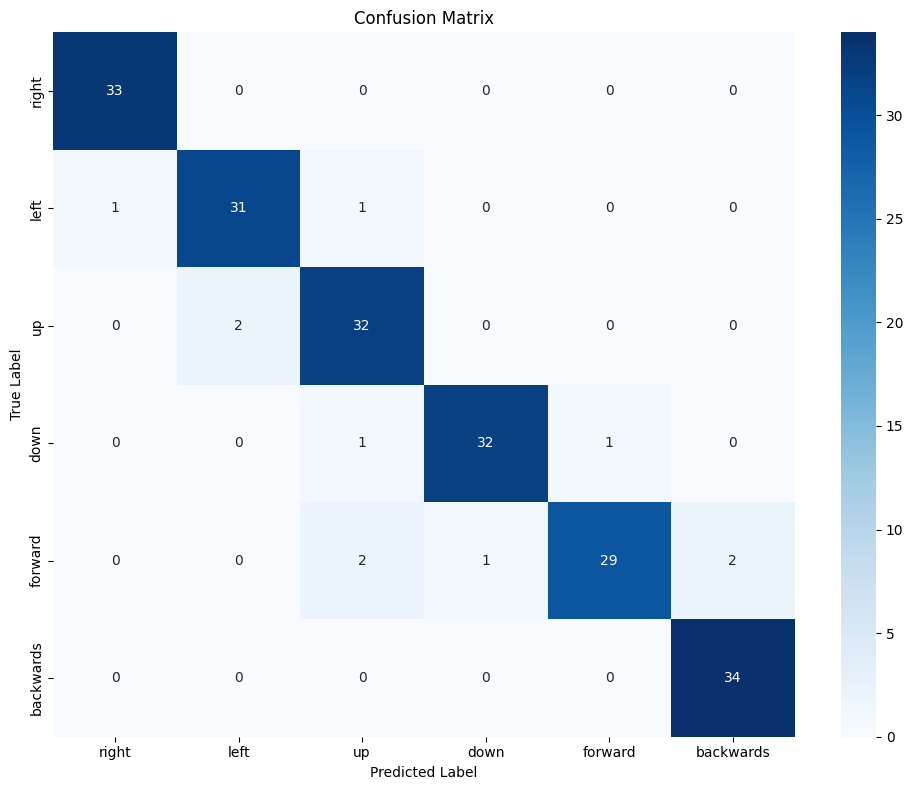

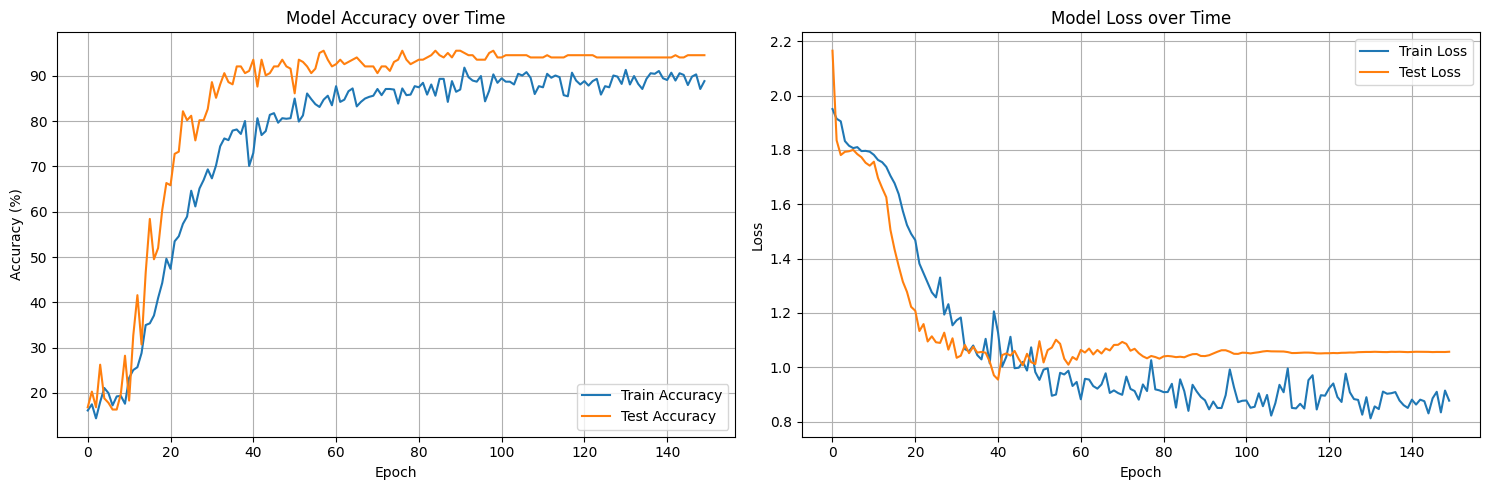

In [20]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

class TopChannelTrainer:
    def __init__(self, model_class, model_params, device):
        self.model_class = model_class
        self.model_params = model_params
        self.device = device
        self.model = None
        self.history = defaultdict(list)
        
    def prepare_data(self, data_dict, selected_channels, window_size=300, stride=250, test_size=0.2):
        """
        Prepare windowed data using only selected channels
        """
        all_X = []
        all_y = []
        valid_classes = ['right', 'left', 'up', 'down', 'forward', 'backwards']
        class_mapping = {class_name: idx for idx, class_name in enumerate(valid_classes)}
        
        print("Processing data...")
        
        # Process each class
        for class_name, data in data_dict.items():
            # Extract valid class name
            valid_class = None
            for vc in valid_classes:
                if vc in class_name.lower():
                    valid_class = vc
                    break
            
            if valid_class is None:
                print(f"Skipping invalid class: {class_name}")
                continue
                
            # Remove time column if present and get EEG data
            data = data.drop('Time', axis=1, errors='ignore')
            eeg_data = data.values.T  # shape: [channels, time]
            
            # Select only the specified channels
            eeg_data = eeg_data[selected_channels, :]
            
            # Create windows
            n_samples = eeg_data.shape[1]
            n_windows = (n_samples - window_size) // stride + 1
            
            for w in range(n_windows):
                start = w * stride
                end = start + window_size
                window = eeg_data[:, start:end]
                
                all_X.append(window)
                all_y.append(class_mapping[valid_class])
        
        if not all_X:
            raise ValueError("No valid data was processed!")
            
        # Convert to numpy arrays
        X = np.stack(all_X)
        y = np.array(all_y)
        
        print("\nData statistics:")
        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")
        
        print("\nNumber of samples per class:")
        for class_name, class_idx in class_mapping.items():
            count = np.sum(y == class_idx)
            print(f"{class_name}: {count}")
        
        # Normalize the data
        print("\nNormalizing data...")
        X = (X - np.mean(X)) / (np.std(X) + 1e-8)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # Convert to PyTorch format
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.tensor(y_train, dtype=torch.long)
        y_test = torch.tensor(y_test, dtype=torch.long)
        
        print(f"\nFinal shapes:")
        print(f"Training data: {X_train.shape}")
        print(f"Training labels: {y_train.shape}")
        print(f"Test data: {X_test.shape}")
        print(f"Test labels: {y_test.shape}")
        
        return X_train, X_test, y_train, y_test
    
    def train(self, X_train, X_test, y_train, y_test, batch_size=128, num_epochs=150):
        """
        Train the model using the selected channels
        """
        # Create data loaders
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)
        
        # Initialize model
        self.model = self.model_class(**self.model_params).to(self.device)
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-3)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
        
        best_acc = 0
        best_model = None
        
        print("\nStarting training...")
        for epoch in range(num_epochs):
            # Training phase
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), 
                              desc=f"Epoch {epoch+1}/{num_epochs}")
            
            for batch_idx, (inputs, labels) in progress_bar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs, _ = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                progress_bar.set_postfix({
                    'loss': f"{train_loss/(batch_idx+1):.4f}",
                    'acc': f"{100*train_correct/train_total:.2f}%"
                })
            
            # Calculate epoch metrics
            epoch_train_loss = train_loss / len(train_loader)
            epoch_train_acc = 100 * train_correct / train_total
            
            # Test phase
            test_acc, test_loss = self.evaluate(test_loader, criterion)
            scheduler.step(test_acc)
            
            # Store metrics
            self.history['train_loss'].append(epoch_train_loss)
            self.history['train_acc'].append(epoch_train_acc)
            self.history['test_loss'].append(test_loss)
            self.history['test_acc'].append(test_acc)
            
            # Save best model
            if test_acc > best_acc:
                best_acc = test_acc
                best_model = self.model.state_dict()
            
            print(f"\nEpoch {epoch+1}/{num_epochs}:")
            print(f"Train Loss: {epoch_train_loss:.4f}")
            print(f"Train Accuracy: {epoch_train_acc:.2f}%")
            print(f"Test Loss: {test_loss:.4f}")
            print(f"Test Accuracy: {test_acc:.2f}%")
        
        # Load best model
        self.model.load_state_dict(best_model)
        print(f"\nBest Test Accuracy: {best_acc:.2f}%")
        
        # Final evaluation metrics
        y_true, y_pred = self.get_predictions(test_loader)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        
        print("\nFinal Metrics:")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
        # Plot confusion matrix
        self.plot_confusion_matrix(y_true, y_pred)
        
        # Plot training curves
        self.plot_training_curves()
        
        return best_acc, precision, recall, f1
    
    def evaluate(self, data_loader, criterion=None):
        """
        Evaluate the model
        """
        self.model.eval()
        correct = 0
        total = 0
        total_loss = 0
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs, _ = self.model(inputs)
                
                if criterion is not None:
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        avg_loss = total_loss / len(data_loader) if criterion is not None else 0
        
        return accuracy, avg_loss
    
    def get_predictions(self, data_loader):
        """
        Get predictions for the entire dataset
        """
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs = inputs.to(self.device)
                outputs, _ = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        return np.array(all_labels), np.array(all_preds)
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """
        Plot confusion matrix
        """
        class_names = ['right', 'left', 'up', 'down', 'forward', 'backwards']
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    def plot_training_curves(self):
        """
        Plot training and validation curves
        """
        plt.figure(figsize=(15, 5))
        
        # Plot accuracies
        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_acc'], label='Train Accuracy')
        plt.plot(self.history['test_acc'], label='Test Accuracy')
        plt.title('Model Accuracy over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True)
        
        # Plot losses
        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['test_loss'], label='Test Loss')
        plt.title('Model Loss over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    top_channels = [6, 5, 3]  # The top 3 channels from the ablation analysis
    
    trainer = TopChannelTrainer(
        model_class=ImprovedMultiscaleDilatedResNet,
        model_params={
            'input_dim': 300,
            'input_channels': len(top_channels),
            'feature_dim': 128,
            'output_dim': 50,
            'num_classes': 6
        },
        device=device
    )
    
    X_train, X_test, y_train, y_test = trainer.prepare_data(
        data_dict=eeg_data,
        selected_channels=top_channels,
        window_size=300,
        stride=250
    )
    
    best_acc, precision, recall, f1 = trainer.train(X_train, X_test, y_train, y_test)

Using device: cuda
Processing data...
Skipping invalid class: 20240831164105_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831153747_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831154734_S11 HMLMIRSR H_multidirection
Skipping invalid class: 20240831161608_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831164559_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831161457_S11 HMLMIRSR H_multidirection
Skipping invalid class: 20240831163519_S11 HMLMIRSR H_multidirection
Skipping invalid class: 20240831160437_S11 HMLMIRSR H_multidirection
Skipping invalid class: 20240831163630_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831154845_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831154230_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831164448_S11 HMLMIRSR H_multidirection
Skipping invalid class: 20240831163954_S11 HMLMIRSR H_multidirection
Skipping invalid class: 20240831160548_S11 HMLMIRSR H_circles
Skipping invalid class: 20240831154119_S11 HMLMIRSR 

Epoch 1/150: 100%|██████████| 7/7 [00:00<00:00, 12.24it/s, loss=1.9440, acc=19.23%]



Epoch 1/150:
Train Loss: 1.9440
Train Accuracy: 19.23%
Test Loss: 1.9124
Test Accuracy: 17.33%


Epoch 2/150: 100%|██████████| 7/7 [00:00<00:00, 12.54it/s, loss=1.9387, acc=16.50%]



Epoch 2/150:
Train Loss: 1.9387
Train Accuracy: 16.50%
Test Loss: 1.8671
Test Accuracy: 16.83%


Epoch 3/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=1.8806, acc=16.25%]



Epoch 3/150:
Train Loss: 1.8806
Train Accuracy: 16.25%
Test Loss: 1.8807
Test Accuracy: 16.83%


Epoch 4/150: 100%|██████████| 7/7 [00:00<00:00, 12.56it/s, loss=1.8571, acc=17.25%]



Epoch 4/150:
Train Loss: 1.8571
Train Accuracy: 17.25%
Test Loss: 1.8170
Test Accuracy: 20.79%


Epoch 5/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=1.8408, acc=17.37%]



Epoch 5/150:
Train Loss: 1.8408
Train Accuracy: 17.37%
Test Loss: 1.8118
Test Accuracy: 24.75%


Epoch 6/150: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s, loss=1.8088, acc=18.73%]



Epoch 6/150:
Train Loss: 1.8088
Train Accuracy: 18.73%
Test Loss: 1.7685
Test Accuracy: 21.78%


Epoch 7/150: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s, loss=1.8090, acc=18.98%]



Epoch 7/150:
Train Loss: 1.8090
Train Accuracy: 18.98%
Test Loss: 1.7894
Test Accuracy: 25.74%


Epoch 8/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=1.7867, acc=19.11%]



Epoch 8/150:
Train Loss: 1.7867
Train Accuracy: 19.11%
Test Loss: 1.7623
Test Accuracy: 25.74%


Epoch 9/150: 100%|██████████| 7/7 [00:00<00:00, 12.59it/s, loss=1.7861, acc=23.70%]



Epoch 9/150:
Train Loss: 1.7861
Train Accuracy: 23.70%
Test Loss: 1.7243
Test Accuracy: 32.67%


Epoch 10/150: 100%|██████████| 7/7 [00:00<00:00, 12.60it/s, loss=1.7868, acc=21.84%]



Epoch 10/150:
Train Loss: 1.7868
Train Accuracy: 21.84%
Test Loss: 1.7249
Test Accuracy: 25.25%


Epoch 11/150: 100%|██████████| 7/7 [00:00<00:00, 12.56it/s, loss=1.7672, acc=23.33%]



Epoch 11/150:
Train Loss: 1.7672
Train Accuracy: 23.33%
Test Loss: 1.6952
Test Accuracy: 26.24%


Epoch 12/150: 100%|██████████| 7/7 [00:00<00:00, 12.59it/s, loss=1.7463, acc=26.67%]



Epoch 12/150:
Train Loss: 1.7463
Train Accuracy: 26.67%
Test Loss: 1.6162
Test Accuracy: 33.66%


Epoch 13/150: 100%|██████████| 7/7 [00:00<00:00, 12.56it/s, loss=1.7155, acc=28.66%]



Epoch 13/150:
Train Loss: 1.7155
Train Accuracy: 28.66%
Test Loss: 1.6210
Test Accuracy: 37.13%


Epoch 14/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=1.6929, acc=30.02%]



Epoch 14/150:
Train Loss: 1.6929
Train Accuracy: 30.02%
Test Loss: 1.4854
Test Accuracy: 45.54%


Epoch 15/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=1.6313, acc=35.61%]



Epoch 15/150:
Train Loss: 1.6313
Train Accuracy: 35.61%
Test Loss: 1.4167
Test Accuracy: 53.96%


Epoch 16/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=1.6135, acc=39.70%]



Epoch 16/150:
Train Loss: 1.6135
Train Accuracy: 39.70%
Test Loss: 1.3466
Test Accuracy: 50.99%


Epoch 17/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=1.5206, acc=42.68%]



Epoch 17/150:
Train Loss: 1.5206
Train Accuracy: 42.68%
Test Loss: 1.3380
Test Accuracy: 57.43%


Epoch 18/150: 100%|██████████| 7/7 [00:00<00:00, 12.76it/s, loss=1.5261, acc=44.04%]



Epoch 18/150:
Train Loss: 1.5261
Train Accuracy: 44.04%
Test Loss: 1.2511
Test Accuracy: 63.37%


Epoch 19/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=1.5131, acc=45.04%]



Epoch 19/150:
Train Loss: 1.5131
Train Accuracy: 45.04%
Test Loss: 1.2142
Test Accuracy: 66.83%


Epoch 20/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=1.4485, acc=48.76%]



Epoch 20/150:
Train Loss: 1.4485
Train Accuracy: 48.76%
Test Loss: 1.1817
Test Accuracy: 66.83%


Epoch 21/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=1.3840, acc=52.48%]



Epoch 21/150:
Train Loss: 1.3840
Train Accuracy: 52.48%
Test Loss: 1.1470
Test Accuracy: 72.77%


Epoch 22/150: 100%|██████████| 7/7 [00:00<00:00, 12.47it/s, loss=1.3767, acc=54.34%]



Epoch 22/150:
Train Loss: 1.3767
Train Accuracy: 54.34%
Test Loss: 1.1507
Test Accuracy: 74.26%


Epoch 23/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=1.3517, acc=55.71%]



Epoch 23/150:
Train Loss: 1.3517
Train Accuracy: 55.71%
Test Loss: 1.1097
Test Accuracy: 75.74%


Epoch 24/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=1.3486, acc=58.44%]



Epoch 24/150:
Train Loss: 1.3486
Train Accuracy: 58.44%
Test Loss: 1.1041
Test Accuracy: 75.25%


Epoch 25/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=1.2619, acc=63.65%]



Epoch 25/150:
Train Loss: 1.2619
Train Accuracy: 63.65%
Test Loss: 1.1361
Test Accuracy: 74.26%


Epoch 26/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=1.2547, acc=61.54%]



Epoch 26/150:
Train Loss: 1.2547
Train Accuracy: 61.54%
Test Loss: 1.1184
Test Accuracy: 84.16%


Epoch 27/150: 100%|██████████| 7/7 [00:00<00:00, 12.59it/s, loss=1.2336, acc=64.64%]



Epoch 27/150:
Train Loss: 1.2336
Train Accuracy: 64.64%
Test Loss: 1.1057
Test Accuracy: 81.68%


Epoch 28/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=1.1802, acc=70.84%]



Epoch 28/150:
Train Loss: 1.1802
Train Accuracy: 70.84%
Test Loss: 1.1360
Test Accuracy: 79.70%


Epoch 29/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=1.1301, acc=70.60%]



Epoch 29/150:
Train Loss: 1.1301
Train Accuracy: 70.60%
Test Loss: 1.1310
Test Accuracy: 83.66%


Epoch 30/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=1.1183, acc=70.47%]



Epoch 30/150:
Train Loss: 1.1183
Train Accuracy: 70.47%
Test Loss: 1.1367
Test Accuracy: 82.18%


Epoch 31/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=1.0748, acc=76.18%]



Epoch 31/150:
Train Loss: 1.0748
Train Accuracy: 76.18%
Test Loss: 1.1813
Test Accuracy: 83.66%


Epoch 32/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=1.1952, acc=67.99%]



Epoch 32/150:
Train Loss: 1.1952
Train Accuracy: 67.99%
Test Loss: 1.0711
Test Accuracy: 85.64%


Epoch 33/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=1.1542, acc=68.73%]



Epoch 33/150:
Train Loss: 1.1542
Train Accuracy: 68.73%
Test Loss: 1.0403
Test Accuracy: 88.12%


Epoch 34/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=1.1311, acc=70.22%]



Epoch 34/150:
Train Loss: 1.1311
Train Accuracy: 70.22%
Test Loss: 1.1724
Test Accuracy: 85.15%


Epoch 35/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=1.1457, acc=71.84%]



Epoch 35/150:
Train Loss: 1.1457
Train Accuracy: 71.84%
Test Loss: 1.1754
Test Accuracy: 83.66%


Epoch 36/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=1.1946, acc=72.70%]



Epoch 36/150:
Train Loss: 1.1946
Train Accuracy: 72.70%
Test Loss: 1.1236
Test Accuracy: 82.67%


Epoch 37/150: 100%|██████████| 7/7 [00:00<00:00, 12.60it/s, loss=1.1277, acc=73.82%]



Epoch 37/150:
Train Loss: 1.1277
Train Accuracy: 73.82%
Test Loss: 1.0647
Test Accuracy: 85.64%


Epoch 38/150: 100%|██████████| 7/7 [00:00<00:00, 12.60it/s, loss=1.0955, acc=73.95%]



Epoch 38/150:
Train Loss: 1.0955
Train Accuracy: 73.95%
Test Loss: 1.0814
Test Accuracy: 85.15%


Epoch 39/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=1.0488, acc=76.43%]



Epoch 39/150:
Train Loss: 1.0488
Train Accuracy: 76.43%
Test Loss: 1.1423
Test Accuracy: 85.15%


Epoch 40/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=1.0220, acc=77.17%]



Epoch 40/150:
Train Loss: 1.0220
Train Accuracy: 77.17%
Test Loss: 1.0953
Test Accuracy: 86.14%


Epoch 41/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=1.0976, acc=77.54%]



Epoch 41/150:
Train Loss: 1.0976
Train Accuracy: 77.54%
Test Loss: 1.0528
Test Accuracy: 89.11%


Epoch 42/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=1.0672, acc=77.05%]



Epoch 42/150:
Train Loss: 1.0672
Train Accuracy: 77.05%
Test Loss: 1.0812
Test Accuracy: 87.13%


Epoch 43/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=1.0040, acc=80.02%]



Epoch 43/150:
Train Loss: 1.0040
Train Accuracy: 80.02%
Test Loss: 1.0577
Test Accuracy: 89.11%


Epoch 44/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=1.0315, acc=80.02%]



Epoch 44/150:
Train Loss: 1.0315
Train Accuracy: 80.02%
Test Loss: 1.0455
Test Accuracy: 91.09%


Epoch 45/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=1.0777, acc=76.92%]



Epoch 45/150:
Train Loss: 1.0777
Train Accuracy: 76.92%
Test Loss: 1.0797
Test Accuracy: 90.10%


Epoch 46/150: 100%|██████████| 7/7 [00:00<00:00, 12.59it/s, loss=1.0510, acc=77.79%]



Epoch 46/150:
Train Loss: 1.0510
Train Accuracy: 77.79%
Test Loss: 1.0912
Test Accuracy: 90.10%


Epoch 47/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=1.0227, acc=79.78%]



Epoch 47/150:
Train Loss: 1.0227
Train Accuracy: 79.78%
Test Loss: 1.0857
Test Accuracy: 87.62%


Epoch 48/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=1.0306, acc=77.79%]



Epoch 48/150:
Train Loss: 1.0306
Train Accuracy: 77.79%
Test Loss: 1.0903
Test Accuracy: 87.13%


Epoch 49/150: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s, loss=1.0088, acc=79.03%]



Epoch 49/150:
Train Loss: 1.0088
Train Accuracy: 79.03%
Test Loss: 1.0684
Test Accuracy: 91.58%


Epoch 50/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=1.0436, acc=80.27%]



Epoch 50/150:
Train Loss: 1.0436
Train Accuracy: 80.27%
Test Loss: 1.1166
Test Accuracy: 84.16%


Epoch 51/150: 100%|██████████| 7/7 [00:00<00:00, 12.60it/s, loss=1.0514, acc=78.29%]



Epoch 51/150:
Train Loss: 1.0514
Train Accuracy: 78.29%
Test Loss: 1.0471
Test Accuracy: 89.60%


Epoch 52/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.9954, acc=80.40%]



Epoch 52/150:
Train Loss: 0.9954
Train Accuracy: 80.40%
Test Loss: 1.0252
Test Accuracy: 91.09%


Epoch 53/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.9955, acc=81.39%]



Epoch 53/150:
Train Loss: 0.9955
Train Accuracy: 81.39%
Test Loss: 1.0250
Test Accuracy: 92.08%


Epoch 54/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.9424, acc=82.01%]



Epoch 54/150:
Train Loss: 0.9424
Train Accuracy: 82.01%
Test Loss: 1.0614
Test Accuracy: 90.10%


Epoch 55/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.9744, acc=81.64%]



Epoch 55/150:
Train Loss: 0.9744
Train Accuracy: 81.64%
Test Loss: 1.0709
Test Accuracy: 91.09%


Epoch 56/150: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s, loss=0.9774, acc=80.40%]



Epoch 56/150:
Train Loss: 0.9774
Train Accuracy: 80.40%
Test Loss: 1.0629
Test Accuracy: 91.58%


Epoch 57/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.9879, acc=83.50%]



Epoch 57/150:
Train Loss: 0.9879
Train Accuracy: 83.50%
Test Loss: 1.0871
Test Accuracy: 88.61%


Epoch 58/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.9750, acc=80.02%]



Epoch 58/150:
Train Loss: 0.9750
Train Accuracy: 80.02%
Test Loss: 1.0949
Test Accuracy: 89.11%


Epoch 59/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.9690, acc=81.76%]



Epoch 59/150:
Train Loss: 0.9690
Train Accuracy: 81.76%
Test Loss: 1.0513
Test Accuracy: 90.59%


Epoch 60/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=1.0333, acc=81.02%]



Epoch 60/150:
Train Loss: 1.0333
Train Accuracy: 81.02%
Test Loss: 1.0985
Test Accuracy: 87.13%


Epoch 61/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=0.9515, acc=81.14%]



Epoch 61/150:
Train Loss: 0.9515
Train Accuracy: 81.14%
Test Loss: 1.0687
Test Accuracy: 91.09%


Epoch 62/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=0.9181, acc=84.49%]



Epoch 62/150:
Train Loss: 0.9181
Train Accuracy: 84.49%
Test Loss: 1.0913
Test Accuracy: 93.07%


Epoch 63/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.9273, acc=84.00%]



Epoch 63/150:
Train Loss: 0.9273
Train Accuracy: 84.00%
Test Loss: 1.1683
Test Accuracy: 87.13%


Epoch 64/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.8914, acc=86.60%]



Epoch 64/150:
Train Loss: 0.8914
Train Accuracy: 86.60%
Test Loss: 1.1352
Test Accuracy: 90.10%


Epoch 65/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9429, acc=84.00%]



Epoch 65/150:
Train Loss: 0.9429
Train Accuracy: 84.00%
Test Loss: 1.1185
Test Accuracy: 90.59%


Epoch 66/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.9126, acc=84.99%]



Epoch 66/150:
Train Loss: 0.9126
Train Accuracy: 84.99%
Test Loss: 1.0815
Test Accuracy: 89.60%


Epoch 67/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=0.9846, acc=84.00%]



Epoch 67/150:
Train Loss: 0.9846
Train Accuracy: 84.00%
Test Loss: 1.1042
Test Accuracy: 87.13%


Epoch 68/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.9011, acc=85.86%]



Epoch 68/150:
Train Loss: 0.9011
Train Accuracy: 85.86%
Test Loss: 1.0653
Test Accuracy: 88.12%


Epoch 69/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.9590, acc=86.85%]



Epoch 69/150:
Train Loss: 0.9590
Train Accuracy: 86.85%
Test Loss: 1.0655
Test Accuracy: 87.62%


Epoch 70/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.9818, acc=84.62%]



Epoch 70/150:
Train Loss: 0.9818
Train Accuracy: 84.62%
Test Loss: 1.0150
Test Accuracy: 92.08%


Epoch 71/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9609, acc=83.25%]



Epoch 71/150:
Train Loss: 0.9609
Train Accuracy: 83.25%
Test Loss: 1.1246
Test Accuracy: 87.13%


Epoch 72/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.9526, acc=85.86%]



Epoch 72/150:
Train Loss: 0.9526
Train Accuracy: 85.86%
Test Loss: 1.1011
Test Accuracy: 87.62%


Epoch 73/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9404, acc=82.88%]



Epoch 73/150:
Train Loss: 0.9404
Train Accuracy: 82.88%
Test Loss: 1.0769
Test Accuracy: 93.07%


Epoch 74/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.9938, acc=81.89%]



Epoch 74/150:
Train Loss: 0.9938
Train Accuracy: 81.89%
Test Loss: 1.0803
Test Accuracy: 92.08%


Epoch 75/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8864, acc=86.97%]



Epoch 75/150:
Train Loss: 0.8864
Train Accuracy: 86.97%
Test Loss: 1.1040
Test Accuracy: 90.59%


Epoch 76/150: 100%|██████████| 7/7 [00:00<00:00, 12.60it/s, loss=0.9651, acc=84.62%]



Epoch 76/150:
Train Loss: 0.9651
Train Accuracy: 84.62%
Test Loss: 1.0820
Test Accuracy: 90.10%


Epoch 77/150: 100%|██████████| 7/7 [00:00<00:00, 12.72it/s, loss=0.8943, acc=86.97%]



Epoch 77/150:
Train Loss: 0.8943
Train Accuracy: 86.97%
Test Loss: 1.0947
Test Accuracy: 89.11%


Epoch 78/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8836, acc=89.08%]



Epoch 78/150:
Train Loss: 0.8836
Train Accuracy: 89.08%
Test Loss: 1.1081
Test Accuracy: 87.62%


Epoch 79/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.8633, acc=88.34%]



Epoch 79/150:
Train Loss: 0.8633
Train Accuracy: 88.34%
Test Loss: 1.0869
Test Accuracy: 89.60%


Epoch 80/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8469, acc=88.34%]



Epoch 80/150:
Train Loss: 0.8469
Train Accuracy: 88.34%
Test Loss: 1.0968
Test Accuracy: 91.58%


Epoch 81/150: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s, loss=0.8688, acc=88.09%]



Epoch 81/150:
Train Loss: 0.8688
Train Accuracy: 88.09%
Test Loss: 1.1058
Test Accuracy: 91.09%


Epoch 82/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.8741, acc=86.48%]



Epoch 82/150:
Train Loss: 0.8741
Train Accuracy: 86.48%
Test Loss: 1.1018
Test Accuracy: 90.59%


Epoch 83/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.9080, acc=86.23%]



Epoch 83/150:
Train Loss: 0.9080
Train Accuracy: 86.23%
Test Loss: 1.0753
Test Accuracy: 92.08%


Epoch 84/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.8607, acc=88.96%]



Epoch 84/150:
Train Loss: 0.8607
Train Accuracy: 88.96%
Test Loss: 1.0688
Test Accuracy: 93.56%


Epoch 85/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8492, acc=88.34%]



Epoch 85/150:
Train Loss: 0.8492
Train Accuracy: 88.34%
Test Loss: 1.1170
Test Accuracy: 91.09%


Epoch 86/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8885, acc=89.21%]



Epoch 86/150:
Train Loss: 0.8885
Train Accuracy: 89.21%
Test Loss: 1.1058
Test Accuracy: 92.08%


Epoch 87/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.9136, acc=88.96%]



Epoch 87/150:
Train Loss: 0.9136
Train Accuracy: 88.96%
Test Loss: 1.0393
Test Accuracy: 92.08%


Epoch 88/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.9293, acc=84.12%]



Epoch 88/150:
Train Loss: 0.9293
Train Accuracy: 84.12%
Test Loss: 1.0550
Test Accuracy: 92.08%


Epoch 89/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.9030, acc=87.47%]



Epoch 89/150:
Train Loss: 0.9030
Train Accuracy: 87.47%
Test Loss: 1.0588
Test Accuracy: 93.56%


Epoch 90/150: 100%|██████████| 7/7 [00:00<00:00, 12.59it/s, loss=0.9058, acc=89.21%]



Epoch 90/150:
Train Loss: 0.9058
Train Accuracy: 89.21%
Test Loss: 1.0629
Test Accuracy: 92.08%


Epoch 91/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8923, acc=86.72%]



Epoch 91/150:
Train Loss: 0.8923
Train Accuracy: 86.72%
Test Loss: 1.0618
Test Accuracy: 93.56%


Epoch 92/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.8606, acc=88.59%]



Epoch 92/150:
Train Loss: 0.8606
Train Accuracy: 88.59%
Test Loss: 1.1027
Test Accuracy: 93.07%


Epoch 93/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.8239, acc=90.57%]



Epoch 93/150:
Train Loss: 0.8239
Train Accuracy: 90.57%
Test Loss: 1.1205
Test Accuracy: 90.59%


Epoch 94/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8643, acc=88.34%]



Epoch 94/150:
Train Loss: 0.8643
Train Accuracy: 88.34%
Test Loss: 1.1259
Test Accuracy: 91.09%


Epoch 95/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8570, acc=89.21%]



Epoch 95/150:
Train Loss: 0.8570
Train Accuracy: 89.21%
Test Loss: 1.1011
Test Accuracy: 91.58%


Epoch 96/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.8347, acc=90.32%]



Epoch 96/150:
Train Loss: 0.8347
Train Accuracy: 90.32%
Test Loss: 1.1251
Test Accuracy: 92.08%


Epoch 97/150: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s, loss=0.8523, acc=90.45%]



Epoch 97/150:
Train Loss: 0.8523
Train Accuracy: 90.45%
Test Loss: 1.1576
Test Accuracy: 91.58%


Epoch 98/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.8344, acc=89.95%]



Epoch 98/150:
Train Loss: 0.8344
Train Accuracy: 89.95%
Test Loss: 1.1588
Test Accuracy: 91.09%


Epoch 99/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=0.8774, acc=89.21%]



Epoch 99/150:
Train Loss: 0.8774
Train Accuracy: 89.21%
Test Loss: 1.1460
Test Accuracy: 91.09%


Epoch 100/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8996, acc=87.22%]



Epoch 100/150:
Train Loss: 0.8996
Train Accuracy: 87.22%
Test Loss: 1.1018
Test Accuracy: 92.08%


Epoch 101/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.9380, acc=86.60%]



Epoch 101/150:
Train Loss: 0.9380
Train Accuracy: 86.60%
Test Loss: 1.0780
Test Accuracy: 93.07%


Epoch 102/150: 100%|██████████| 7/7 [00:00<00:00, 12.60it/s, loss=0.8716, acc=89.45%]



Epoch 102/150:
Train Loss: 0.8716
Train Accuracy: 89.45%
Test Loss: 1.0887
Test Accuracy: 93.07%


Epoch 103/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=0.8716, acc=88.46%]



Epoch 103/150:
Train Loss: 0.8716
Train Accuracy: 88.46%
Test Loss: 1.1042
Test Accuracy: 94.06%


Epoch 104/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8852, acc=89.21%]



Epoch 104/150:
Train Loss: 0.8852
Train Accuracy: 89.21%
Test Loss: 1.1104
Test Accuracy: 93.56%


Epoch 105/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8304, acc=89.58%]



Epoch 105/150:
Train Loss: 0.8304
Train Accuracy: 89.58%
Test Loss: 1.1071
Test Accuracy: 93.56%


Epoch 106/150: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s, loss=0.8656, acc=90.57%]



Epoch 106/150:
Train Loss: 0.8656
Train Accuracy: 90.57%
Test Loss: 1.1095
Test Accuracy: 92.08%


Epoch 107/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.9258, acc=88.96%]



Epoch 107/150:
Train Loss: 0.9258
Train Accuracy: 88.96%
Test Loss: 1.1099
Test Accuracy: 91.58%


Epoch 108/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.8835, acc=87.47%]



Epoch 108/150:
Train Loss: 0.8835
Train Accuracy: 87.47%
Test Loss: 1.0683
Test Accuracy: 95.05%


Epoch 109/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8884, acc=86.97%]



Epoch 109/150:
Train Loss: 0.8884
Train Accuracy: 86.97%
Test Loss: 1.0684
Test Accuracy: 95.05%


Epoch 110/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8635, acc=89.08%]



Epoch 110/150:
Train Loss: 0.8635
Train Accuracy: 89.08%
Test Loss: 1.0633
Test Accuracy: 95.05%


Epoch 111/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8318, acc=90.07%]



Epoch 111/150:
Train Loss: 0.8318
Train Accuracy: 90.07%
Test Loss: 1.0766
Test Accuracy: 93.07%


Epoch 112/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.8392, acc=91.44%]



Epoch 112/150:
Train Loss: 0.8392
Train Accuracy: 91.44%
Test Loss: 1.1026
Test Accuracy: 93.56%


Epoch 113/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.8290, acc=90.07%]



Epoch 113/150:
Train Loss: 0.8290
Train Accuracy: 90.07%
Test Loss: 1.0912
Test Accuracy: 93.56%


Epoch 114/150: 100%|██████████| 7/7 [00:00<00:00, 12.70it/s, loss=0.8514, acc=88.71%]



Epoch 114/150:
Train Loss: 0.8514
Train Accuracy: 88.71%
Test Loss: 1.0983
Test Accuracy: 93.56%


Epoch 115/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.8178, acc=91.56%]



Epoch 115/150:
Train Loss: 0.8178
Train Accuracy: 91.56%
Test Loss: 1.1067
Test Accuracy: 93.07%


Epoch 116/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.8977, acc=90.45%]



Epoch 116/150:
Train Loss: 0.8977
Train Accuracy: 90.45%
Test Loss: 1.1043
Test Accuracy: 93.56%


Epoch 117/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8947, acc=88.96%]



Epoch 117/150:
Train Loss: 0.8947
Train Accuracy: 88.96%
Test Loss: 1.1000
Test Accuracy: 95.05%


Epoch 118/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.9125, acc=89.21%]



Epoch 118/150:
Train Loss: 0.9125
Train Accuracy: 89.21%
Test Loss: 1.0839
Test Accuracy: 95.05%


Epoch 119/150: 100%|██████████| 7/7 [00:00<00:00, 12.59it/s, loss=0.8721, acc=86.72%]



Epoch 119/150:
Train Loss: 0.8721
Train Accuracy: 86.72%
Test Loss: 1.0736
Test Accuracy: 94.55%


Epoch 120/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8780, acc=88.71%]



Epoch 120/150:
Train Loss: 0.8780
Train Accuracy: 88.71%
Test Loss: 1.0892
Test Accuracy: 94.55%


Epoch 121/150: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s, loss=0.8934, acc=89.58%]



Epoch 121/150:
Train Loss: 0.8934
Train Accuracy: 89.58%
Test Loss: 1.0946
Test Accuracy: 94.06%


Epoch 122/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.8188, acc=91.69%]



Epoch 122/150:
Train Loss: 0.8188
Train Accuracy: 91.69%
Test Loss: 1.0908
Test Accuracy: 93.56%


Epoch 123/150: 100%|██████████| 7/7 [00:00<00:00, 12.61it/s, loss=0.9243, acc=87.72%]



Epoch 123/150:
Train Loss: 0.9243
Train Accuracy: 87.72%
Test Loss: 1.0926
Test Accuracy: 93.07%


Epoch 124/150: 100%|██████████| 7/7 [00:00<00:00, 12.69it/s, loss=0.8969, acc=89.08%]



Epoch 124/150:
Train Loss: 0.8969
Train Accuracy: 89.08%
Test Loss: 1.0859
Test Accuracy: 93.07%


Epoch 125/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.8304, acc=90.32%]



Epoch 125/150:
Train Loss: 0.8304
Train Accuracy: 90.32%
Test Loss: 1.0969
Test Accuracy: 93.07%


Epoch 126/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.8516, acc=88.59%]



Epoch 126/150:
Train Loss: 0.8516
Train Accuracy: 88.59%
Test Loss: 1.1051
Test Accuracy: 92.57%


Epoch 127/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=0.9015, acc=89.33%]



Epoch 127/150:
Train Loss: 0.9015
Train Accuracy: 89.33%
Test Loss: 1.0999
Test Accuracy: 92.57%


Epoch 128/150: 100%|██████████| 7/7 [00:00<00:00, 12.57it/s, loss=0.8474, acc=90.57%]



Epoch 128/150:
Train Loss: 0.8474
Train Accuracy: 90.57%
Test Loss: 1.0877
Test Accuracy: 93.56%


Epoch 129/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8772, acc=89.58%]



Epoch 129/150:
Train Loss: 0.8772
Train Accuracy: 89.58%
Test Loss: 1.0932
Test Accuracy: 93.07%


Epoch 130/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8756, acc=89.70%]



Epoch 130/150:
Train Loss: 0.8756
Train Accuracy: 89.70%
Test Loss: 1.0944
Test Accuracy: 92.57%


Epoch 131/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8273, acc=90.07%]



Epoch 131/150:
Train Loss: 0.8273
Train Accuracy: 90.07%
Test Loss: 1.0988
Test Accuracy: 93.07%


Epoch 132/150: 100%|██████████| 7/7 [00:00<00:00, 12.71it/s, loss=0.8747, acc=89.21%]



Epoch 132/150:
Train Loss: 0.8747
Train Accuracy: 89.21%
Test Loss: 1.1013
Test Accuracy: 93.56%


Epoch 133/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.7982, acc=92.80%]



Epoch 133/150:
Train Loss: 0.7982
Train Accuracy: 92.80%
Test Loss: 1.1030
Test Accuracy: 94.06%


Epoch 134/150: 100%|██████████| 7/7 [00:00<00:00, 12.60it/s, loss=0.7930, acc=92.06%]



Epoch 134/150:
Train Loss: 0.7930
Train Accuracy: 92.06%
Test Loss: 1.1114
Test Accuracy: 93.56%


Epoch 135/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8073, acc=92.06%]



Epoch 135/150:
Train Loss: 0.8073
Train Accuracy: 92.06%
Test Loss: 1.1197
Test Accuracy: 93.07%


Epoch 136/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.8815, acc=90.07%]



Epoch 136/150:
Train Loss: 0.8815
Train Accuracy: 90.07%
Test Loss: 1.1225
Test Accuracy: 93.07%


Epoch 137/150: 100%|██████████| 7/7 [00:00<00:00, 12.67it/s, loss=0.8570, acc=89.83%]



Epoch 137/150:
Train Loss: 0.8570
Train Accuracy: 89.83%
Test Loss: 1.1221
Test Accuracy: 93.07%


Epoch 138/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=0.8431, acc=91.19%]



Epoch 138/150:
Train Loss: 0.8431
Train Accuracy: 91.19%
Test Loss: 1.1190
Test Accuracy: 92.57%


Epoch 139/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.8570, acc=89.33%]



Epoch 139/150:
Train Loss: 0.8570
Train Accuracy: 89.33%
Test Loss: 1.1199
Test Accuracy: 92.08%


Epoch 140/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8122, acc=92.43%]



Epoch 140/150:
Train Loss: 0.8122
Train Accuracy: 92.43%
Test Loss: 1.1128
Test Accuracy: 92.57%


Epoch 141/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.8199, acc=92.06%]



Epoch 141/150:
Train Loss: 0.8199
Train Accuracy: 92.06%
Test Loss: 1.1102
Test Accuracy: 93.07%


Epoch 142/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8781, acc=90.69%]



Epoch 142/150:
Train Loss: 0.8781
Train Accuracy: 90.69%
Test Loss: 1.1096
Test Accuracy: 93.07%


Epoch 143/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.9494, acc=88.21%]



Epoch 143/150:
Train Loss: 0.9494
Train Accuracy: 88.21%
Test Loss: 1.1126
Test Accuracy: 93.56%


Epoch 144/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.8689, acc=90.07%]



Epoch 144/150:
Train Loss: 0.8689
Train Accuracy: 90.07%
Test Loss: 1.1082
Test Accuracy: 93.56%


Epoch 145/150: 100%|██████████| 7/7 [00:00<00:00, 12.66it/s, loss=0.8296, acc=90.07%]



Epoch 145/150:
Train Loss: 0.8296
Train Accuracy: 90.07%
Test Loss: 1.1045
Test Accuracy: 93.07%


Epoch 146/150: 100%|██████████| 7/7 [00:00<00:00, 12.68it/s, loss=0.7984, acc=92.56%]



Epoch 146/150:
Train Loss: 0.7984
Train Accuracy: 92.56%
Test Loss: 1.1033
Test Accuracy: 93.56%


Epoch 147/150: 100%|██████████| 7/7 [00:00<00:00, 12.62it/s, loss=0.8275, acc=91.69%]



Epoch 147/150:
Train Loss: 0.8275
Train Accuracy: 91.69%
Test Loss: 1.1032
Test Accuracy: 93.07%


Epoch 148/150: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, loss=0.7772, acc=92.56%]



Epoch 148/150:
Train Loss: 0.7772
Train Accuracy: 92.56%
Test Loss: 1.1050
Test Accuracy: 93.07%


Epoch 149/150: 100%|██████████| 7/7 [00:00<00:00, 12.65it/s, loss=0.8262, acc=90.07%]



Epoch 149/150:
Train Loss: 0.8262
Train Accuracy: 90.07%
Test Loss: 1.1041
Test Accuracy: 93.07%


Epoch 150/150: 100%|██████████| 7/7 [00:00<00:00, 12.64it/s, loss=0.8129, acc=90.94%]



Epoch 150/150:
Train Loss: 0.8129
Train Accuracy: 90.94%
Test Loss: 1.1028
Test Accuracy: 93.07%

Best Test Accuracy: 95.05%

Detailed Classification Report:
              precision    recall  f1-score   support

       right     1.0000    1.0000    1.0000        33
        left     0.9697    0.9697    0.9697        33
          up     0.8462    0.9706    0.9041        34
        down     0.8857    0.9118    0.8986        34
     forward     1.0000    0.7353    0.8475        34
   backwards     0.9189    1.0000    0.9577        34

    accuracy                         0.9307       202
   macro avg     0.9367    0.9312    0.9296       202
weighted avg     0.9363    0.9307    0.9290       202


Per-Class Metrics:

Detailed Per-Class Performance:
Class       Precision     Recall   F1-Score    Support
-------------------------------------------------------
right          1.0000     1.0000     1.0000         33
left           0.9697     0.9697     0.9697         33
up             0.8462   

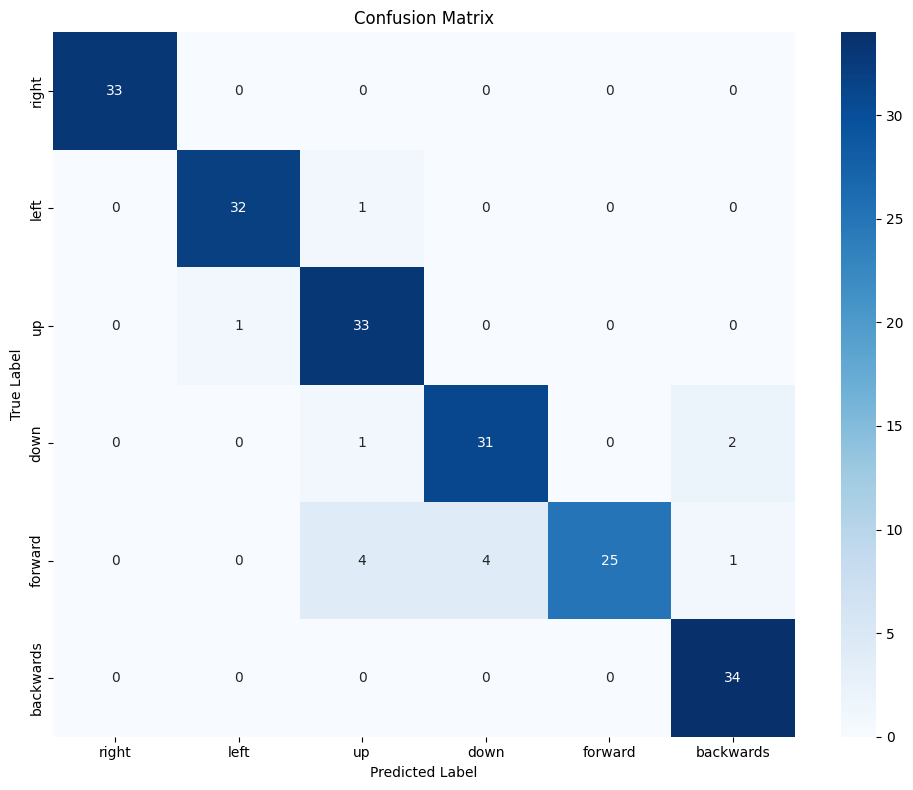

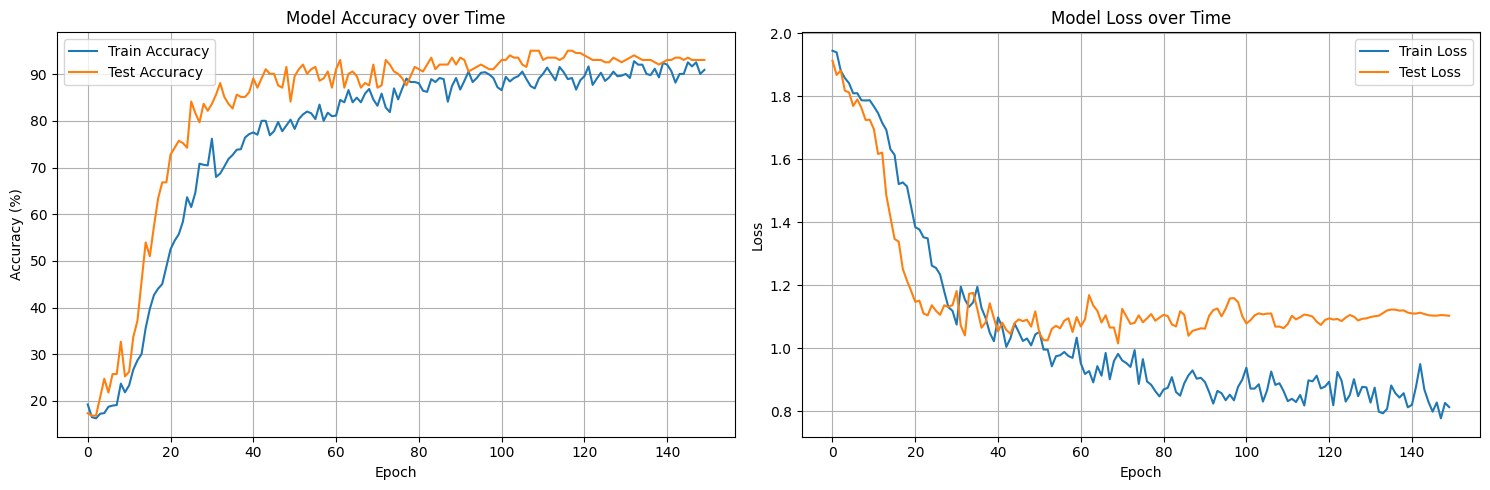

In [21]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

class TopChannelTrainer:
    def __init__(self, model_class, model_params, device):
        self.model_class = model_class
        self.model_params = model_params
        self.device = device
        self.model = None
        self.history = defaultdict(list)
        
    def prepare_data(self, data_dict, selected_channels, window_size=300, stride=250, test_size=0.2):
        """
        Prepare windowed data using only selected channels
        """
        all_X = []
        all_y = []
        valid_classes = ['right', 'left', 'up', 'down', 'forward', 'backwards']
        class_mapping = {class_name: idx for idx, class_name in enumerate(valid_classes)}
        
        print("Processing data...")
        
        # Process each class
        for class_name, data in data_dict.items():
            # Extract valid class name
            valid_class = None
            for vc in valid_classes:
                if vc in class_name.lower():
                    valid_class = vc
                    break
            
            if valid_class is None:
                print(f"Skipping invalid class: {class_name}")
                continue
                
            # Remove time column if present and get EEG data
            data = data.drop('Time', axis=1, errors='ignore')
            eeg_data = data.values.T  # shape: [channels, time]
            
            # Select only the specified channels
            eeg_data = eeg_data[selected_channels, :]
            
            # Create windows
            n_samples = eeg_data.shape[1]
            n_windows = (n_samples - window_size) // stride + 1
            
            for w in range(n_windows):
                start = w * stride
                end = start + window_size
                window = eeg_data[:, start:end]
                
                all_X.append(window)
                all_y.append(class_mapping[valid_class])
        
        if not all_X:
            raise ValueError("No valid data was processed!")
            
        # Convert to numpy arrays
        X = np.stack(all_X)
        y = np.array(all_y)
        
        print("\nData statistics:")
        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")
        
        print("\nNumber of samples per class:")
        for class_name, class_idx in class_mapping.items():
            count = np.sum(y == class_idx)
            print(f"{class_name}: {count}")
        
        # Normalize the data
        print("\nNormalizing data...")
        X = (X - np.mean(X)) / (np.std(X) + 1e-8)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # Convert to PyTorch format
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.tensor(y_train, dtype=torch.long)
        y_test = torch.tensor(y_test, dtype=torch.long)
        
        print(f"\nFinal shapes:")
        print(f"Training data: {X_train.shape}")
        print(f"Training labels: {y_train.shape}")
        print(f"Test data: {X_test.shape}")
        print(f"Test labels: {y_test.shape}")
        
        return X_train, X_test, y_train, y_test
    
    def train(self, X_train, X_test, y_train, y_test, batch_size=128, num_epochs=150):
        """
        Train the model using the selected channels
        """
        # Create data loaders
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)
        
        # Initialize model
        self.model = self.model_class(**self.model_params).to(self.device)
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-3)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
        
        best_acc = 0
        best_model = None
        
        print("\nStarting training...")
        for epoch in range(num_epochs):
            # Training phase
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), 
                              desc=f"Epoch {epoch+1}/{num_epochs}")
            
            for batch_idx, (inputs, labels) in progress_bar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs, _ = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                progress_bar.set_postfix({
                    'loss': f"{train_loss/(batch_idx+1):.4f}",
                    'acc': f"{100*train_correct/train_total:.2f}%"
                })
            
            # Calculate epoch metrics
            epoch_train_loss = train_loss / len(train_loader)
            epoch_train_acc = 100 * train_correct / train_total
            
            # Test phase
            test_acc, test_loss = self.evaluate(test_loader, criterion)
            scheduler.step(test_acc)
            
            # Store metrics
            self.history['train_loss'].append(epoch_train_loss)
            self.history['train_acc'].append(epoch_train_acc)
            self.history['test_loss'].append(test_loss)
            self.history['test_acc'].append(test_acc)
            
            # Save best model
            if test_acc > best_acc:
                best_acc = test_acc
                best_model = self.model.state_dict()
            
            print(f"\nEpoch {epoch+1}/{num_epochs}:")
            print(f"Train Loss: {epoch_train_loss:.4f}")
            print(f"Train Accuracy: {epoch_train_acc:.2f}%")
            print(f"Test Loss: {test_loss:.4f}")
            print(f"Test Accuracy: {test_acc:.2f}%")
        
        # Load best model
        self.model.load_state_dict(best_model)
        print(f"\nBest Test Accuracy: {best_acc:.2f}%")
        
        # Get predictions for final evaluation
        y_true, y_pred = self.get_predictions(test_loader)
        
        # Calculate final metrics
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        
        # Print detailed classification report
        class_names = ['right', 'left', 'up', 'down', 'forward', 'backwards']
        print("\nDetailed Classification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
        
        print("\nPer-Class Metrics:")
        precision_per_class, recall_per_class, f1_per_class, support_per_class = \
            precision_recall_fscore_support(y_true, y_pred, labels=range(len(class_names)))
            
        print("\nDetailed Per-Class Performance:")
        print(f"{'Class':<10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
        print("-" * 55)
        for i, class_name in enumerate(class_names):
            print(f"{class_name:<10} {precision_per_class[i]:10.4f} {recall_per_class[i]:10.4f} "
                  f"{f1_per_class[i]:10.4f} {support_per_class[i]:10d}")
        print("-" * 55)
        macro_avg = (np.mean(precision_per_class), np.mean(recall_per_class), 
                    np.mean(f1_per_class), np.sum(support_per_class))
        print(f"{'Macro Avg':<10} {macro_avg[0]:10.4f} {macro_avg[1]:10.4f} "
              f"{macro_avg[2]:10.4f} {macro_avg[3]:10d}")
        
        # Plot confusion matrix
        self.plot_confusion_matrix(y_true, y_pred)
        
        # Plot training curves
        self.plot_training_curves()
        
        return best_acc, precision, recall, f1
    
    def evaluate(self, data_loader, criterion=None):
        """
        Evaluate the model
        """
        self.model.eval()
        correct = 0
        total = 0
        total_loss = 0
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs, _ = self.model(inputs)
                
                if criterion is not None:
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        avg_loss = total_loss / len(data_loader) if criterion is not None else 0
        
        return accuracy, avg_loss
    
    def get_predictions(self, data_loader):
        """
        Get predictions for the entire dataset
        """
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs = inputs.to(self.device)
                outputs, _ = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        return np.array(all_labels), np.array(all_preds)
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """
        Plot confusion matrix
        """
        class_names = ['right', 'left', 'up', 'down', 'forward', 'backwards']
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    def plot_training_curves(self):
        """
        Plot training and validation curves
        """
        plt.figure(figsize=(15, 5))
        
        # Plot accuracies
        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_acc'], label='Train Accuracy')
        plt.plot(self.history['test_acc'], label='Test Accuracy')
        plt.title('Model Accuracy over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True)
        
        # Plot losses
        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['test_loss'], label='Test Loss')
        plt.title('Model Loss over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Testing channels 6, 5, and 3
    top_channels = [6, 5, 3]
    
    trainer = TopChannelTrainer(
        model_class=ImprovedMultiscaleDilatedResNet,
        model_params={
            'input_dim': 300,
            'input_channels': len(top_channels),
            'feature_dim': 128,
            'output_dim': 50,
            'num_classes': 6
        },
        device=device
    )
    
    X_train, X_test, y_train, y_test = trainer.prepare_data(
        data_dict=eeg_data,
        selected_channels=top_channels,
        window_size=300,
        stride=250
    )
    
    best_acc, precision, recall, f1 = trainer.train(X_train, X_test, y_train, y_test)